In [160]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx

import matplotlib.pyplot as plt
#import statsmodels.api as sm
import scipy

In [161]:
%matplotlib inline
plt.style.use('default')

In [162]:
data_dir = ".\\data"
img_dir = ".\\img"

output_links_lookup = os.path.join(data_dir, "pavement_links_to_or_links.csv")
output_or_roads = os.path.join(data_dir, "open_roads_clean.shp")

output_road_network = os.path.join(data_dir, "open-roads RoadLink betcen diffs")
road_nodes = os.path.join(data_dir, "open-roads RoadNode Intersect Within simplify angles.shp")
pave_nodes = os.path.join(data_dir, "pedNetworkNodes.shp")
output_pave_links = os.path.join(data_dir, "pednetworkLinksWithCentralities")
output_pave_ex_diag_links = os.path.join(data_dir, "pednetworkLinksExDiagWithCentralities")
output_pave_res_links = os.path.join(data_dir, "pednetworkLinksResWithCentralities")
output_pave_rt_links = os.path.join(data_dir, "pednetworkLinksResTimeWithCentralities")

## Load data

In [163]:
gdfRoadBC = gpd.read_file(output_road_network)
gdfRoadNodes = gpd.read_file(road_nodes)
gdfPaveBC = gpd.read_file(output_pave_links)
gdfPaveExDiagBC = gpd.read_file(output_pave_ex_diag_links)
gdfPaveResBC = gpd.read_file(output_pave_res_links)
gdfPaveRTBC = gpd.read_file(output_pave_rt_links)

gdfPaveNodes = gpd.read_file(pave_nodes)

In [164]:
gdfPaveExDiagBC.head()

MNodeFID        PNodeFID                  fid      linkType  \
0     pave_node_1     pave_node_2        pave_link_1_2  direct_cross   
1     pave_node_1  pave_node_6660     pave_link_1_6660      pavement   
2     pave_node_2  pave_node_6662     pave_link_2_6662      pavement   
3  pave_node_6660  pave_node_6662  pave_link_6660_6662  direct_cross   
4     pave_node_4     pave_node_5        pave_link_4_5  direct_cross   

     pedRLID pedRoadID     length or_link_cr     or_fid  paveExDBC    roadBC  \
0  or_link_0      None  10.938817  or_link_0  or_link_0   0.000027  0.040631   
1       None      None  27.630827       None  or_link_0   0.010175  0.040631   
2       None      None  25.955877       None  or_link_0   0.028747  0.040631   
3  or_link_0      None  10.674244  or_link_0  or_link_0   0.003333  0.040631   
4  or_link_1      None  13.039873  or_link_1  or_link_1   0.000028  0.000469   

   rdBCPaveEx  BCDiffExDi    BCDiffEx_1     paveExDBC_  roadBC_un  BCDfExDiPv  \
0         NaN         NaN           NaN     681.666667   150579.0         NaN   
1    0.020316   -0.010141 -6.734619e-08  260695.000000   150579.0   -0.009286   
2    0.020316    0.008431  5.599117e-08  736548.333333   150579.0    0.009286   
3         NaN         NaN           NaN   85406.666667   150579.0         NaN   
4         NaN         NaN           NaN     714.666667     1737.0         NaN   

                                            geometry  
0  LINESTRING (530022.591 174254.483, 530011.844 ...  
1  LINESTRING (530022.591 174254.483, 530017.186 ...  
2  LINESTRING (530011.844 174256.526, 530007.142 ...  
3  LINESTRING (530017.186 174227.386, 530007.142 ...  
4  LINESTRING (529934.847 174248.823, 529921.870 ...

In [165]:
gdfPaveBC['linkType'].value_counts()

pavement        7138
diag_cross      7103
direct_cross    5986
Name: linkType, dtype: int64

# Aggregate Centrality Comparison

## Centrality Distributions

First compare distributions of centralities between the networks and then compare the centrality values on a link by link basis using regression.

In [166]:
gdfRoadBC.head()

fid   MNodeFID      PNodeFID      length     BCSum  BCSumExDi  \
0  or_link_0  or_node_0  or_node_2558   31.757846  0.038669   0.038921   
1  or_link_1  or_node_1  or_node_2558   85.014484  0.000403   0.000410   
2  or_link_2  or_node_2  or_node_2558   28.258818  0.038934   0.039200   
3  or_link_3  or_node_0     or_node_5   80.179265  0.000714   0.000698   
4  or_link_4  or_node_3     or_node_0  104.560987  0.001560   0.001547   

   BCSumRes   BCSumRT   BCRange  BCRangeExD  BCRangeRes  BCRangeRT    roadBC  \
0  0.037901  0.037949  0.029843         NaN         NaN        NaN  0.040631   
1  0.000384  0.000380  0.000288         NaN    0.000192   0.000189  0.000469   
2  0.038151  0.038190  0.029277         NaN         NaN        NaN  0.040908   
3  0.000726  0.000730  0.000494         NaN    0.000500   0.000504  0.001000   
4  0.001572  0.001585  0.000978         NaN    0.000997   0.001010  0.001778   

   roadBC_un                                           geometry  
0   150579.0  LINESTRING (530018.000 174260.000, 530012.180 ...  
1     1737.0  LINESTRING (529929.610 174249.020, 530012.180 ...  
2   151605.0  LINESTRING (530007.000 174201.000, 530012.180 ...  
3     3707.0  LINESTRING (530018.000 174260.000, 529938.590 ...  
4     6589.0  LINESTRING (530121.000 174242.000, 530018.000 ...

C:\Users\obisargoni\.conda\envs\gforge\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\obisargoni\.conda\envs\gforge\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
<ipython-input-167-f71de0c9f689>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


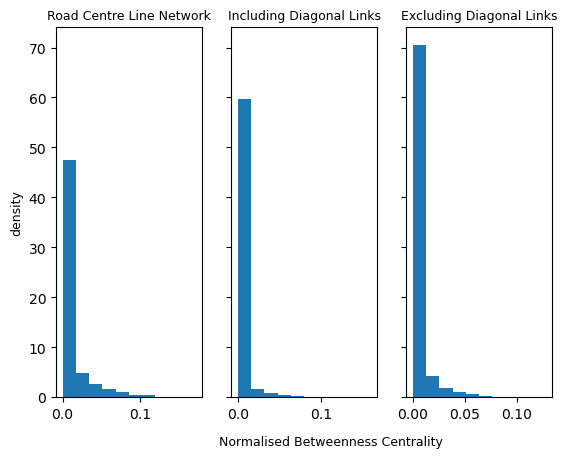

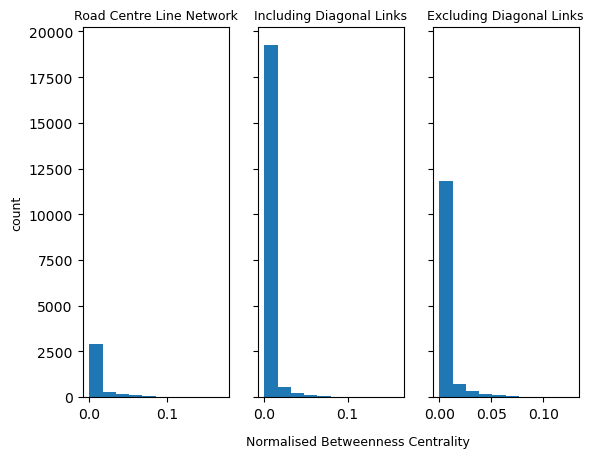

In [167]:
n_bins = 10

for label, d in [ ('density', True), ('count', False) ]:
    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False)

    # We can set the number of bins with the `bins` kwarg
    _ = axs[0].hist(abs(gdfRoadBC['roadBC']), bins=n_bins, density = d)
    _ = axs[1].hist(abs(gdfPaveBC['paveBC']), bins=n_bins, density = d)
    _ = axs[2].hist(abs(gdfPaveExDiagBC['paveExDBC']), bins=n_bins, density = d)

    axis_fontdict = {'fontsize':9}
    axs[0].set_ylabel(label, fontdict = axis_fontdict)
    plt.text(0.38, 0.01, "Normalised Betweenness Centrality", fontdict = axis_fontdict, transform=fig.transFigure)

    title_fontdict = {'fontsize': 9}
    axs[0].set_title("Road Centre Line Network", fontdict = title_fontdict)
    axs[1].set_title("Including Diagonal Links", fontdict = title_fontdict)
    axs[2].set_title("Excluding Diagonal Links", fontdict = title_fontdict)
    
    fig.show()

<ipython-input-168-0f51e821c768>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


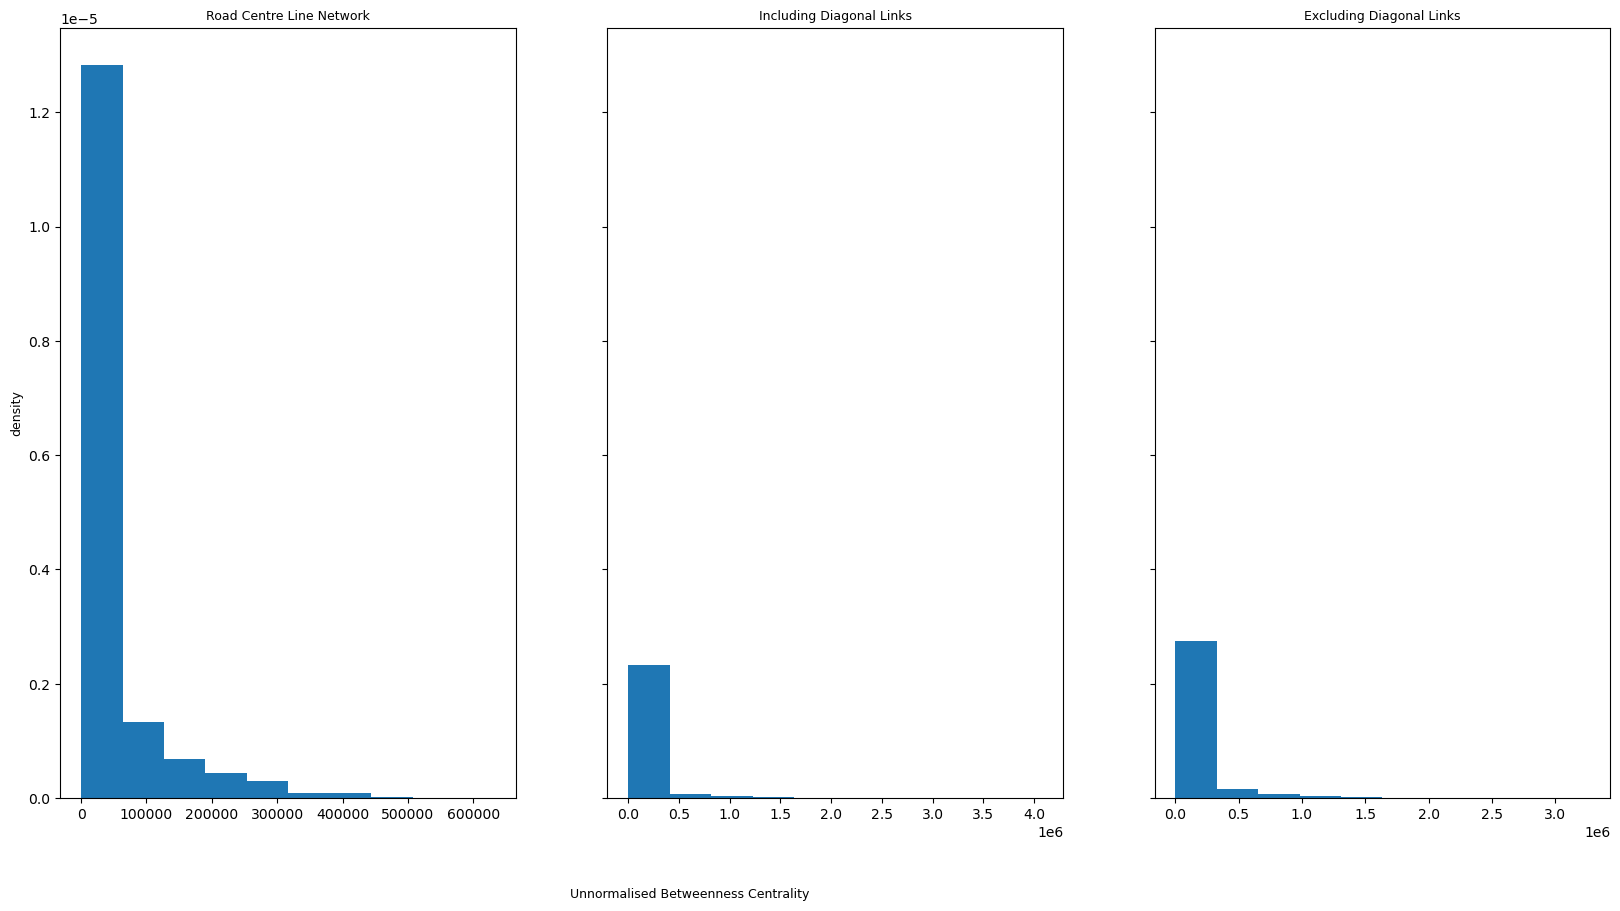

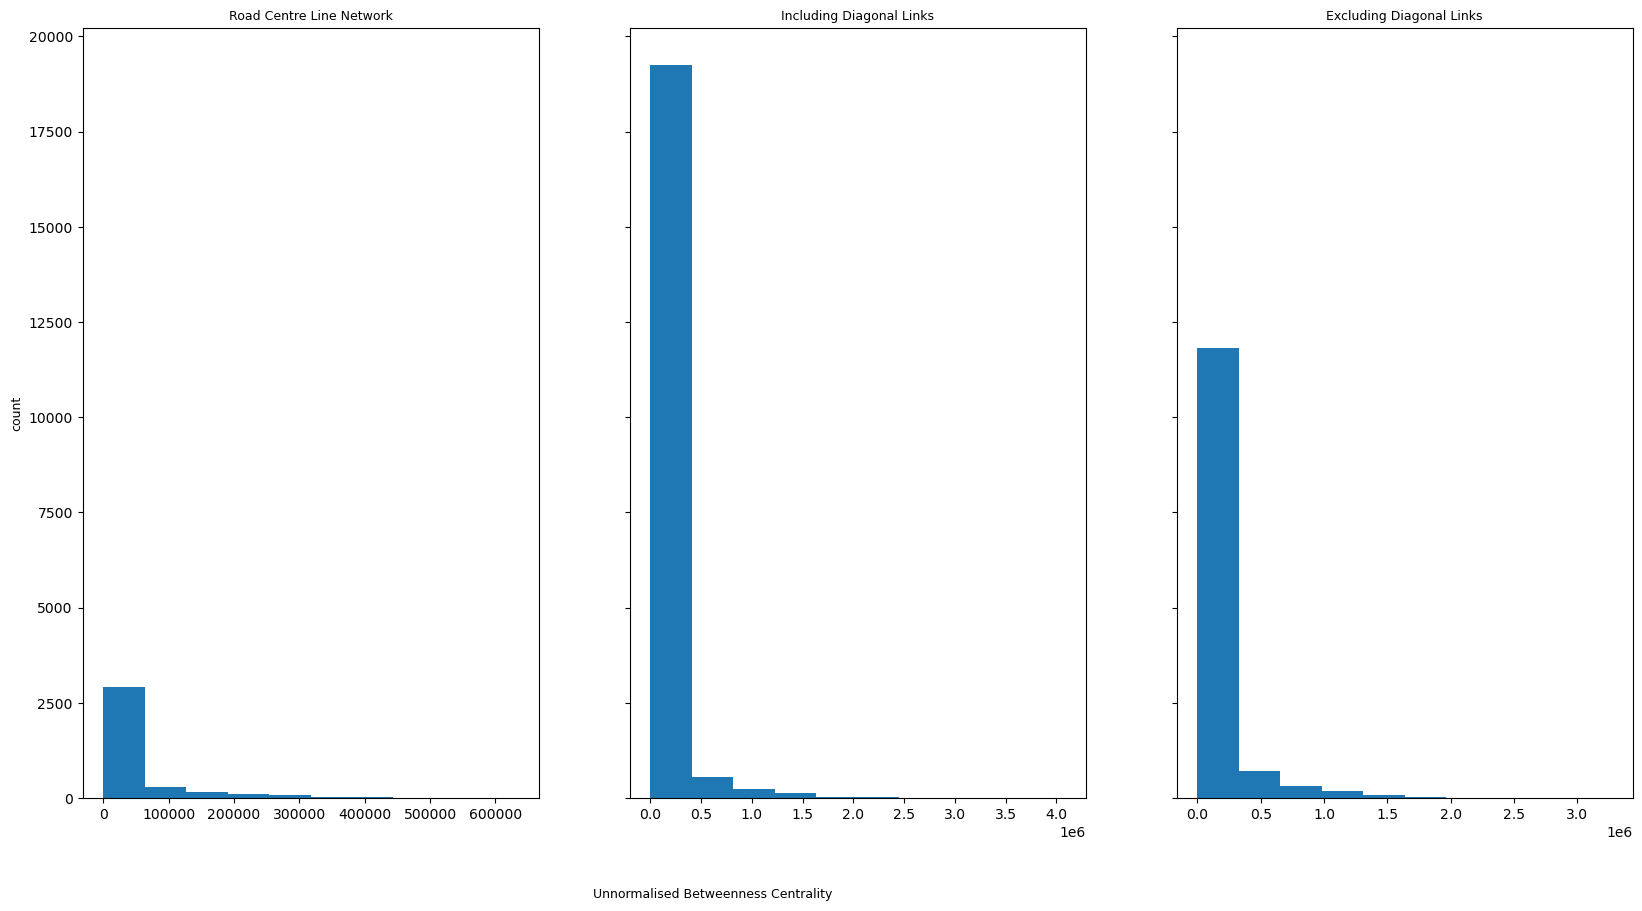

In [168]:
n_bins = 10

for label, d in [ ('density', True), ('count', False) ]:
    fig, axs = plt.subplots(1, 3, figsize=(20,10), sharey=True, tight_layout=False)

    # We can set the number of bins with the `bins` kwarg
    _ = axs[0].hist(abs(gdfRoadBC['roadBC_un']), bins=n_bins, density = d)
    _ = axs[1].hist(abs(gdfPaveBC['paveBC_un']), bins=n_bins, density = d)
    _ = axs[2].hist(abs(gdfPaveExDiagBC['paveExDBC_']), bins=n_bins, density = d)

    axis_fontdict = {'fontsize':9}
    axs[0].set_ylabel(label, fontdict = axis_fontdict)
    plt.text(0.38, 0.01, "Unnormalised Betweenness Centrality", fontdict = axis_fontdict, transform=fig.transFigure)

    title_fontdict = {'fontsize': 9}
    axs[0].set_title("Road Centre Line Network", fontdict = title_fontdict)
    axs[1].set_title("Including Diagonal Links", fontdict = title_fontdict)
    axs[2].set_title("Excluding Diagonal Links", fontdict = title_fontdict)
    
    fig.show()

Text(0.5, 1.0, 'Excluding Diagonal Links')

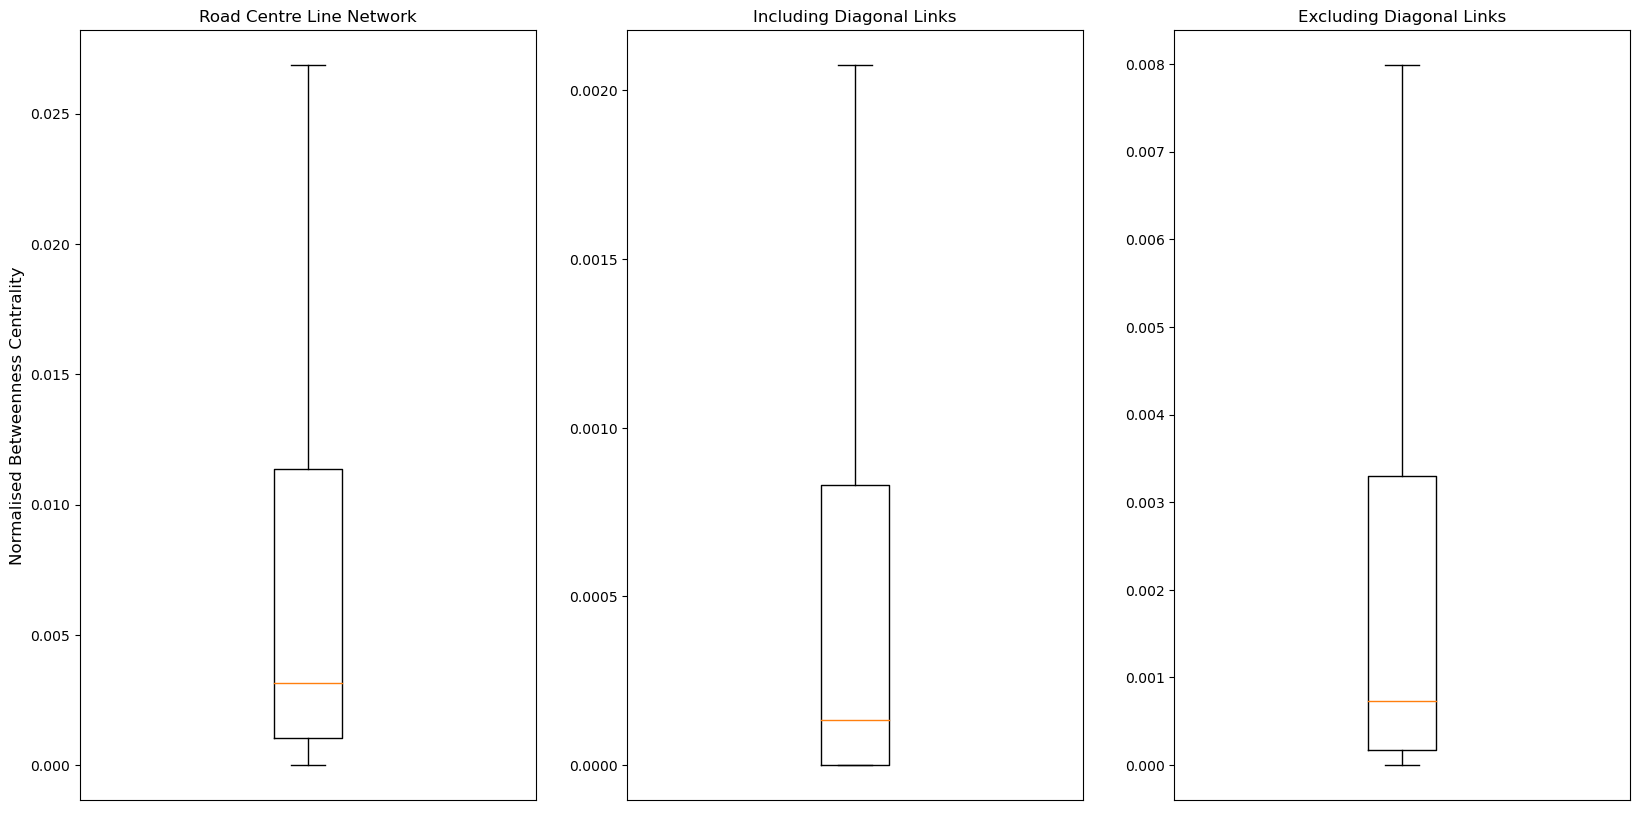

In [169]:
fig, axs = plt.subplots(1, 3, figsize = (20,10), sharey=False, tight_layout=False)

# We can set the number of bins with the `bins` kwarg
_ = axs[0].boxplot(gdfRoadBC['roadBC'].dropna(), vert=True, sym="")
_ = axs[1].boxplot(gdfPaveBC['paveBC'].dropna(), vert=True, sym="")
_ = axs[2].boxplot(gdfPaveExDiagBC['paveExDBC'].dropna(), vert=True, sym="")

axis_fontdict = {'fontsize':12}
axs[0].set_ylabel("Normalised Betweenness Centrality", fontdict = axis_fontdict)

axs[0].set(xlabel=None, xticks=[])
axs[1].set(xlabel=None, xticks=[])
axs[2].set(xlabel=None, xticks=[])

title_fontdict = {'fontsize': 12}
axs[0].set_title("Road Centre Line Network", fontdict = title_fontdict)
axs[1].set_title("Including Diagonal Links", fontdict = title_fontdict)
axs[2].set_title("Excluding Diagonal Links", fontdict = title_fontdict)

## RCL vs pavement centralities

Compare aggregated pavement network centrality values to RCL centrality values

In [170]:
data = gdfRoadBC.loc[:, ['roadBC', 'BCSum']].dropna()

regressor_OLS = sm.OLS(endog=data['roadBC'], exog=sm.add_constant(data['BCSum'])).fit()
regressor_OLS.summary()

NameError: name 'sm' is not defined

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(data['roadBC'], data['BCSum'])
plt.xlabel("RCL betweenness centrality (normalised)")
plt.ylabel("Aggregated UPN betweenness centrality (normalised)")

### Repeat for pavement network excluding diagonal links

In [ ]:
data = gdfRoadBC.loc[:, ['roadBC', 'BCSumExDi']].dropna()

regressor_OLS = sm.OLS(endog=data['roadBC'], exog=sm.add_constant(data['BCSumExDi'])).fit()
regressor_OLS.summary()

#### Differences between regression models

Model fit is higher and coefficient of pavement link centrality is higher too. This suggests that removing the diagonal links from the network makes the remaining links more closely match the road centre line centrality values.

This is unexpected sincec would have though more links would mean that the pavement network more closely matches the 'no barrier' assumption of road centre line.

However, by excluding diagonal links have reduced sample size.

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(data['roadBC'], data['BCSumExDi'])
plt.xlabel("RCL betweenness centrality (normalised)")
plt.ylabel("Aggregated CPN betweenness centrality (normalised)")

# Rank correlation

Calculate spearmans ranks correlation coefficient for the rank of road betweenness centrality and pavement betweenness centrality.

In [ ]:
from scipy import stats

In [ ]:
gdfRoadBC['roadBCRank'] = gdfRoadBC['roadBC'].rank()
gdfRoadBC['BCSumRank'] = gdfRoadBC['BCSum'].rank()
gdfRoadBC['BCSumExDiRank'] = gdfRoadBC['BCSumExDi'].rank()
gdfRoadBC['BCSumResRank'] = gdfRoadBC['BCSumRes'].rank()
gdfRoadBC['BCSumRTRank'] = gdfRoadBC['BCSumRT'].rank()

In [ ]:
data = gdfRoadBC.loc[:, ['roadBCRank', 'BCSumRank']].dropna().values
stats.spearmanr(data, axis=0)

In [ ]:
data = gdfRoadBC.loc[:, ['roadBCRank', 'BCSumExDiRank']].dropna().values
stats.spearmanr(data, axis=0)

In [ ]:
data = gdfRoadBC.loc[:, ['roadBCRank', 'BCSumResRank']].dropna().values
stats.spearmanr(data, axis=0)

In [ ]:
data = gdfRoadBC.loc[:, ['roadBCRank', 'BCSumRTRank']].dropna().values
stats.spearmanr(data, axis=0)

In [ ]:
(gdfRoadBC['BCSumRes'] == gdfRoadBC['BCSumRT']).value_counts()

In [ ]:
# Find links where values are not the same
gdfRoadBC.loc[ gdfRoadBC['BCSumRes']!=gdfRoadBC['BCSumRT'], ['fid','or_fid','BCSumRes','BCSumRT', 'BCSum', 'BCSumExDi', 'BCSumRank']]

In [ ]:
gdfRoadBC['BCSum'].isnull().value_counts()

### Explaining difference between case with diagonal links and case without

When diagonal links not included in the network, meaning that crossings between sides of the road must occur at junctions, higher correlation between road link centrality and pavement link centrality is observed.

This suggests that a pavement network representation that restricts pedestrian crossings to junctions more closely matches a road centre line representation. Diagonal links traverse space differently to pavement links that run approximately parallel to the road centre line. This difference produces betweenness centrality values that are less well correlated with road link centralities.

Does this mean that a pavement network representation would produce different flows on road links?

The rank correlation coefficient confirms the regression analysis results above. When diagonal links are excluded the centrality of the pavement network links more closely matches the centrality of the road network links.

However, the correlation is high in both cases, suggesting that were pedestrians to follow desire line more frequently flows predicted by betweenness centrality would differ only slightly.

## Explaining difference between distributions

Does the difference between aggregated centrality and RCL centrality correlate with centrality?

In [ ]:
gdfRoadBC['aggBCDiff'] = abs(gdfRoadBC['roadBC'] - gdfRoadBC['BCSum'])

data = gdfRoadBC.reindex(columns = ['roadBC', 'aggBCDiff']).dropna()

regressor_OLS = sm.OLS(endog=data['aggBCDiff'], exog=sm.add_constant(data['roadBC'])).fit()
regressor_OLS.summary()

In [ ]:
gdfRoadBC['aggBCDiffExDi'] = abs(gdfRoadBC['roadBC'] - gdfRoadBC['BCSumExDi'])

data = gdfRoadBC.reindex(columns = ['roadBC', 'aggBCDiffExDi']).dropna()

regressor_OLS = sm.OLS(endog=data['aggBCDiffExDi'], exog=sm.add_constant(data['roadBC'])).fit()
regressor_OLS.summary()

The regresstion shows that RCL link centrality is correlated with the difference between aggregated centrality and RCL centrality. This means that one of the assumptions of the regression analysis is violated since errors are not independent.

Also suggests that for more central links, the difference between the pavement network centrality and RCL centrality is greater. This is interesting as it potentially increases the significant of the simplifying RCL assumption. 

However, this dependence could also be caused by the approximate normalisations which perhaps has more of an effect on high centrality links (this would make sense since high centrality links have more paths passing through them, therefore greater need for proper normalisation).

# Disaggregate Centrality Comparison

In this section of analysis I compare the pavement link cecntrality values to the disaggregated RCL centrality values.

## Pavement centrality range

First, look at the distribution of the range of pavement link centrality values

In [171]:
gdfRoadBC.columns

Index(['fid', 'MNodeFID', 'PNodeFID', 'length', 'BCSum', 'BCSumExDi',
       'BCSumRes', 'BCSumRT', 'BCRange', 'BCRangeExD', 'BCRangeRes',
       'BCRangeRT', 'roadBC', 'roadBC_un', 'geometry'],
      dtype='object')

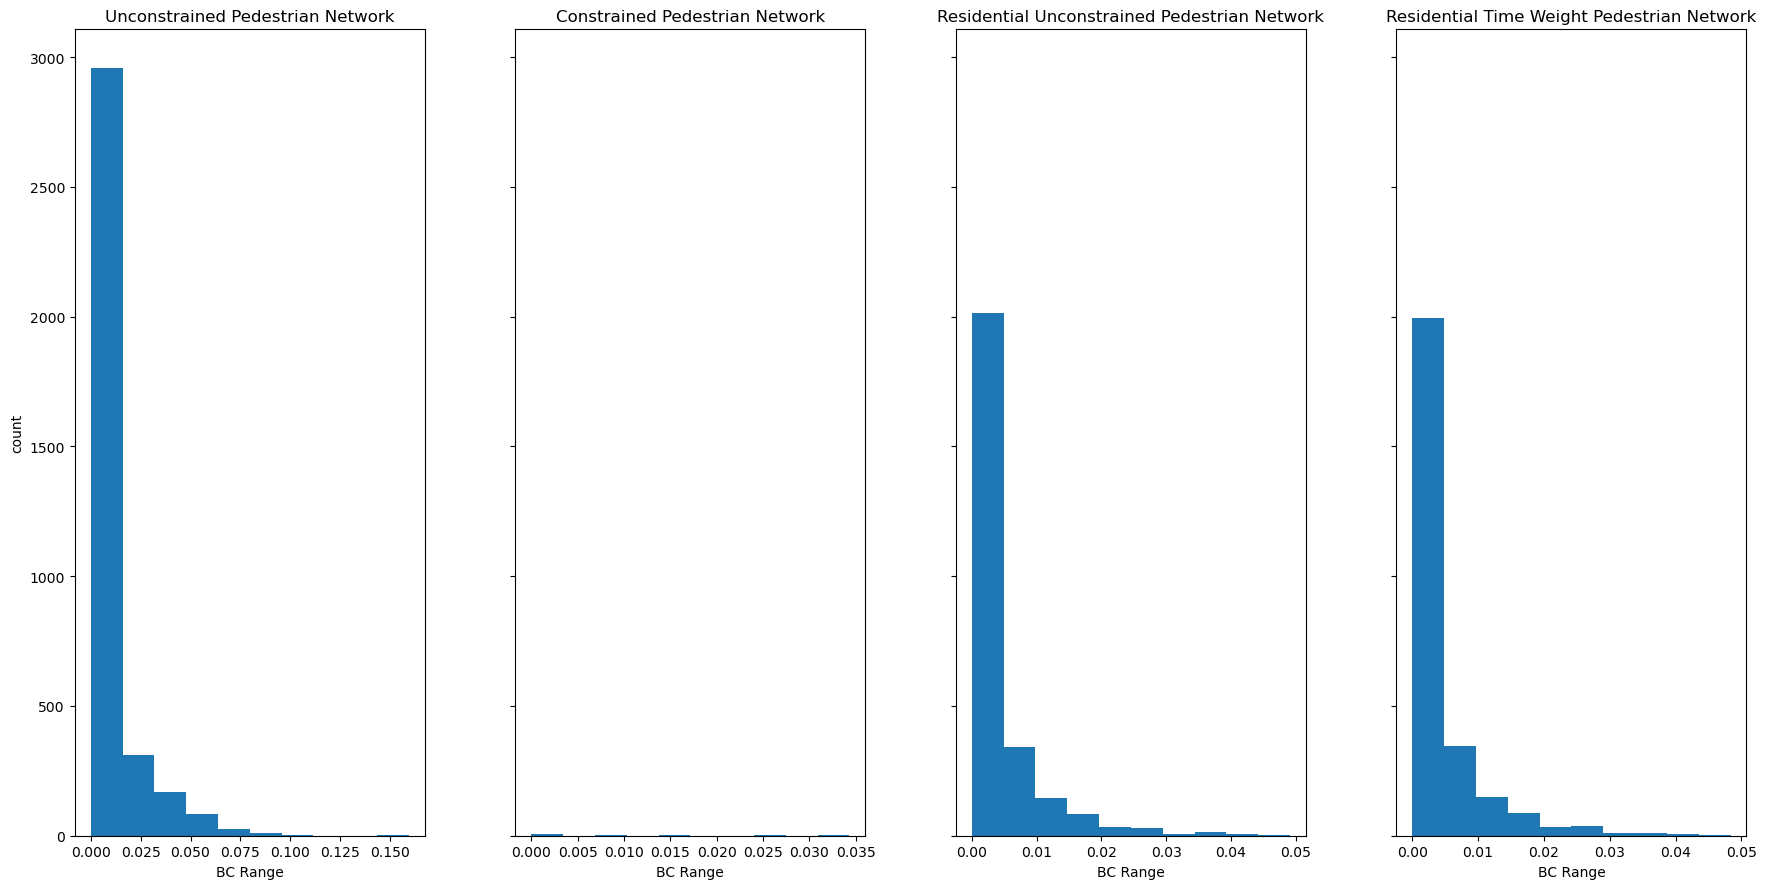

In [172]:
n_bins = 10
fig, axs = plt.subplots(1, 4, figsize = (18,9), sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
_ = axs[0].hist(gdfRoadBC['BCRange'].dropna(), bins=n_bins)
_ = axs[1].hist(gdfRoadBC['BCRangeExD'].dropna(), bins=n_bins)
_ = axs[2].hist(gdfRoadBC['BCRangeRes'].dropna(), bins=n_bins)
_ = axs[3].hist(gdfRoadBC['BCRangeRT'].dropna(), bins=n_bins)

axs[0].set_ylabel("count")
axs[0].set_xlabel("BC Range")
axs[1].set_xlabel("BC Range")
axs[2].set_xlabel("BC Range")
axs[3].set_xlabel("BC Range")

titles = [  "Unconstrained Pedestrian Network",
            "Constrained Pedestrian Network",
            "Residential Unconstrained Pedestrian Network",
            "Residential Time Weight Pedestrian Network"
         ]
for i, title in enumerate(titles):
    axs[i].set_title(title)

C:\Users\obisargoni\.conda\envs\gforge\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\obisargoni\.conda\envs\gforge\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


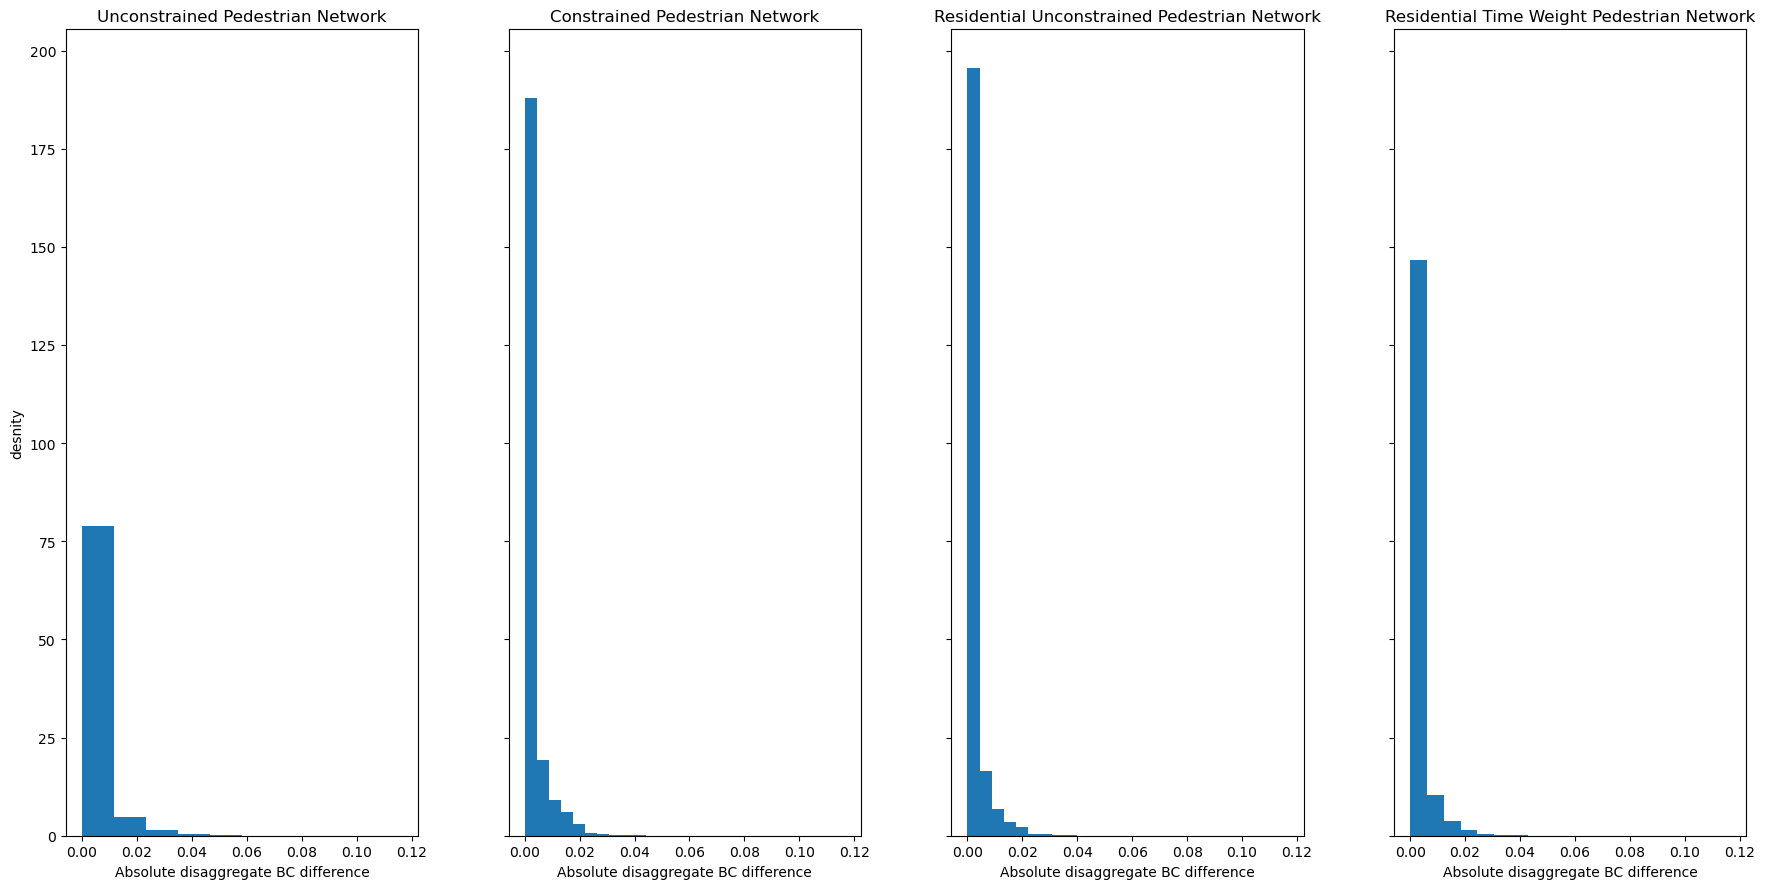

In [173]:
n_bins = 10
fig, axs = plt.subplots(1, 4, figsize = (18,9), sharey=True, sharex=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
_ = axs[0].hist(abs(gdfPaveBC['BCDiff']), bins=n_bins, density=True)
_ = axs[1].hist(abs(gdfPaveExDiagBC['BCDiffExDi']), bins=n_bins, density=True)
_ = axs[2].hist(abs(gdfPaveResBC['BCDiffRes']), bins=n_bins, density=True)
_ = axs[3].hist(abs(gdfPaveRTBC['BCDiffRT']), bins=n_bins, density=True)

axs[0].set_ylabel("desnity")
for ax in axs:
    ax.set_xlabel("Absolute disaggregate BC difference")

for i, title in enumerate(titles):
    axs[i].set_title(title)

## Explaining difference between distributions

A pavement network representation that includes diagonal crossing links produces greater frequency of high betweenness centrality difference between non-crossing pavement links.

By providing an alternative way to move along a road link diagonal links seems to increase the centrality of one side of the road. Certain sides of the road are more frequently included in shortest routes when that side of the road is more easily accessed.

this suggests that the barrier effect plays a role in equalising pedestrian flows on either side of the road. Where the barrier effect is reduced and cariiadgeway space shared between pedestrian and vehicular modes we can expect to see increased pedestrian flow differentials on either side of the road.

## Regression - road link centrality vs difference between disaggregate centrality

### Full pavement network

In [174]:
gdfPaveBC.columns

Index(['MNodeFID', 'PNodeFID', 'fid', 'linkType', 'pedRLID', 'pedRoadID',
       'length', 'or_link_cr', 'or_fid', 'paveBC', 'roadBC', 'rdBCPave',
       'BCDiff', 'BCDiffFr', 'paveBC_un', 'roadBC_un', 'BCDiffPv', 'geometry'],
      dtype='object')

In [175]:
data = gdfPaveBC.reindex(columns = ['roadBC', 'BCDiff']).dropna()

regressor_OLS = sm.OLS(endog=abs(data['BCDiff']), exog=sm.add_constant(data['roadBC'])).fit()
regressor_OLS.summary()

NameError: name 'sm' is not defined

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(data['roadBC'], abs(data['BCDiff']))
fig.suptitle( "Road centrality vs absolute difference between disaggregate road centrality")
plt.xlabel("Road betweenness centrality")
plt.ylabel("Difference between disaggregate centrality")

### Excluding diagonal links

Regression model fit is worse

In [176]:
gdfPaveExDiagBC.columns

Index(['MNodeFID', 'PNodeFID', 'fid', 'linkType', 'pedRLID', 'pedRoadID',
       'length', 'or_link_cr', 'or_fid', 'paveExDBC', 'roadBC', 'rdBCPaveEx',
       'BCDiffExDi', 'BCDiffEx_1', 'paveExDBC_', 'roadBC_un', 'BCDfExDiPv',
       'geometry'],
      dtype='object')

In [177]:
data = gdfPaveExDiagBC.reindex(columns = ['roadBC', 'BCDiffExDi']).dropna()

regressor_OLS = sm.OLS(endog=abs(data['BCDiffExDi']), exog=sm.add_constant(data['roadBC'])).fit()
regressor_OLS.summary()

NameError: name 'sm' is not defined

Text(0, 0.5, 'Difference between disaggregate centrality')

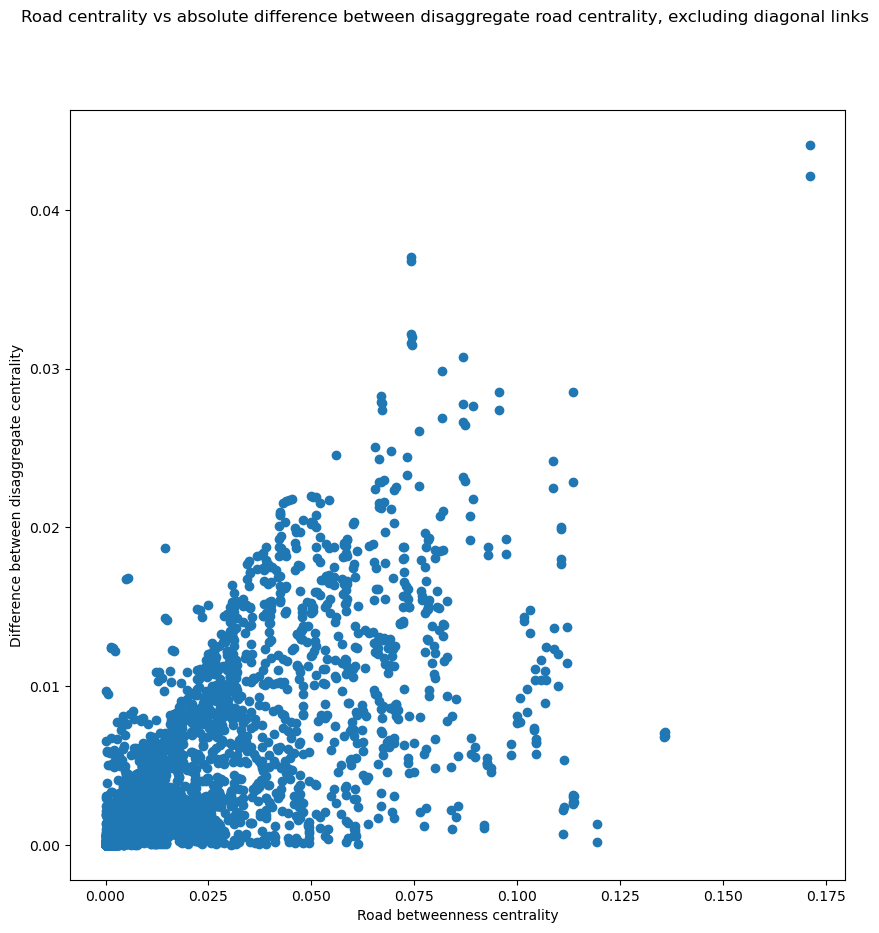

In [178]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(data['roadBC'], abs(data['BCDiffExDi']))
fig.suptitle( "Road centrality vs absolute difference between disaggregate road centrality, excluding diagonal links")
plt.xlabel("Road betweenness centrality")
plt.ylabel("Difference between disaggregate centrality")

## Visualise dissagregate difference on road network

Next compare the the pavement link centrality values to the disaggregated RCL values

In [179]:
gdfPaveBC.columns

Index(['MNodeFID', 'PNodeFID', 'fid', 'linkType', 'pedRLID', 'pedRoadID',
       'length', 'or_link_cr', 'or_fid', 'paveBC', 'roadBC', 'rdBCPave',
       'BCDiff', 'BCDiffFr', 'paveBC_un', 'roadBC_un', 'BCDiffPv', 'geometry'],
      dtype='object')

## Draw network

In [180]:
gdfRoadBC.columns

Index(['fid', 'MNodeFID', 'PNodeFID', 'length', 'BCSum', 'BCSumExDi',
       'BCSumRes', 'BCSumRT', 'BCRange', 'BCRangeExD', 'BCRangeRes',
       'BCRangeRT', 'roadBC', 'roadBC_un', 'geometry'],
      dtype='object')

In [181]:
def road_network_figure(G, dict_node_pos, dict_edge_values, title, cmap_name = 'viridis', edge_width = 3, edge_alpha = 1):

    plt.style.use('dark_background')
    f, ax = plt.subplots(1,1,figsize = (15,15))

    ax = road_network_subfigure(ax, G, dict_node_pos, dict_edge_values, title, cmap_name = cmap_name, edge_width=edge_width, edge_alpha=edge_alpha)
    return f

def road_network_subfigure(ax, G, dict_node_pos, title, edge_color = 'red', edge_cmap = 'bwr', edge_width = 3, edge_alpha = 1, title_font = {'size': 12}, edge_vmin = 0, edge_vmax=1):

    nx.draw_networkx_nodes(G, dict_node_pos, ax = ax, nodelist=G.nodes(), node_color = 'grey', node_size = 1, alpha = 0.2)
    nx.draw_networkx_edges(G, dict_node_pos, ax = ax, edgelist=G.edges(), width = 3, edge_color = edge_color, edge_cmap=edge_cmap, alpha=edge_alpha, edge_vmin = edge_vmin, edge_vmax=edge_vmax)
    ax.set_title(title, fontdict = title_font, y = 0)
    ax.axis('off')
    return ax

In [182]:
# Using the geographical coordinates of the nodes when plotting them
points_pos = gdfPaveNodes.set_index('fid')
points_pos['x'] = points_pos['geometry'].map(lambda g: g.coords[0][0])
points_pos['y'] = points_pos['geometry'].map(lambda g: g.coords[0][1])
node_posistions = list(zip(points_pos['x'], points_pos['y']))
dict_node_pos = dict(zip(points_pos.index, node_posistions))

In [183]:
# Get networkx graph
G_BCDiff = nx.Graph()
edges = gdfPaveBC.loc[:, ['MNodeFID', 'PNodeFID', 'BCDiff']].dropna().values
G_BCDiff.add_weighted_edges_from(edges, weight = 'BCDiff')

G_BCDiffExDi = nx.Graph()
edges = gdfPaveExDiagBC.loc[:, ['MNodeFID', 'PNodeFID', 'BCDiffExDi']].dropna().values
G_BCDiffExDi.add_weighted_edges_from(edges, weight = 'BCDiffExDi')

G_BCDiffRes = nx.Graph()
edges = gdfPaveResBC.loc[:, ['MNodeFID', 'PNodeFID', 'BCDiffRes']].dropna().values
G_BCDiffRes.add_weighted_edges_from(edges, weight = 'BCDiffRes')

G_BCDiffRT = nx.Graph()
edges = gdfPaveRTBC.loc[:, ['MNodeFID', 'PNodeFID', 'BCDiffRT']].dropna().values
G_BCDiffRT.add_weighted_edges_from(edges, weight = 'BCDiffRT')

Draw these sections of the network

In [184]:
# get edge data to color edges by
bcdiff_data = np.array([d[-1] for d in  G_BCDiff.edges.data('BCDiff', default=0)])
bcdiff_exdi_data = np.array([d[-1] for d in G_BCDiffExDi.edges.data('BCDiffExDi', default=0)])
bcdiff_res_data = np.array([d[-1] for d in G_BCDiffRes.edges.data('BCDiffRes', default=0)])
bcdiff_rt_data = np.array([d[-1] for d in G_BCDiffRT.edges.data('BCDiffRT', default=0)])

all_values = np.concatenate([bcdiff_data, bcdiff_exdi_data])
vmin = -1*max(abs(all_values))
vmax = max(abs(all_values))

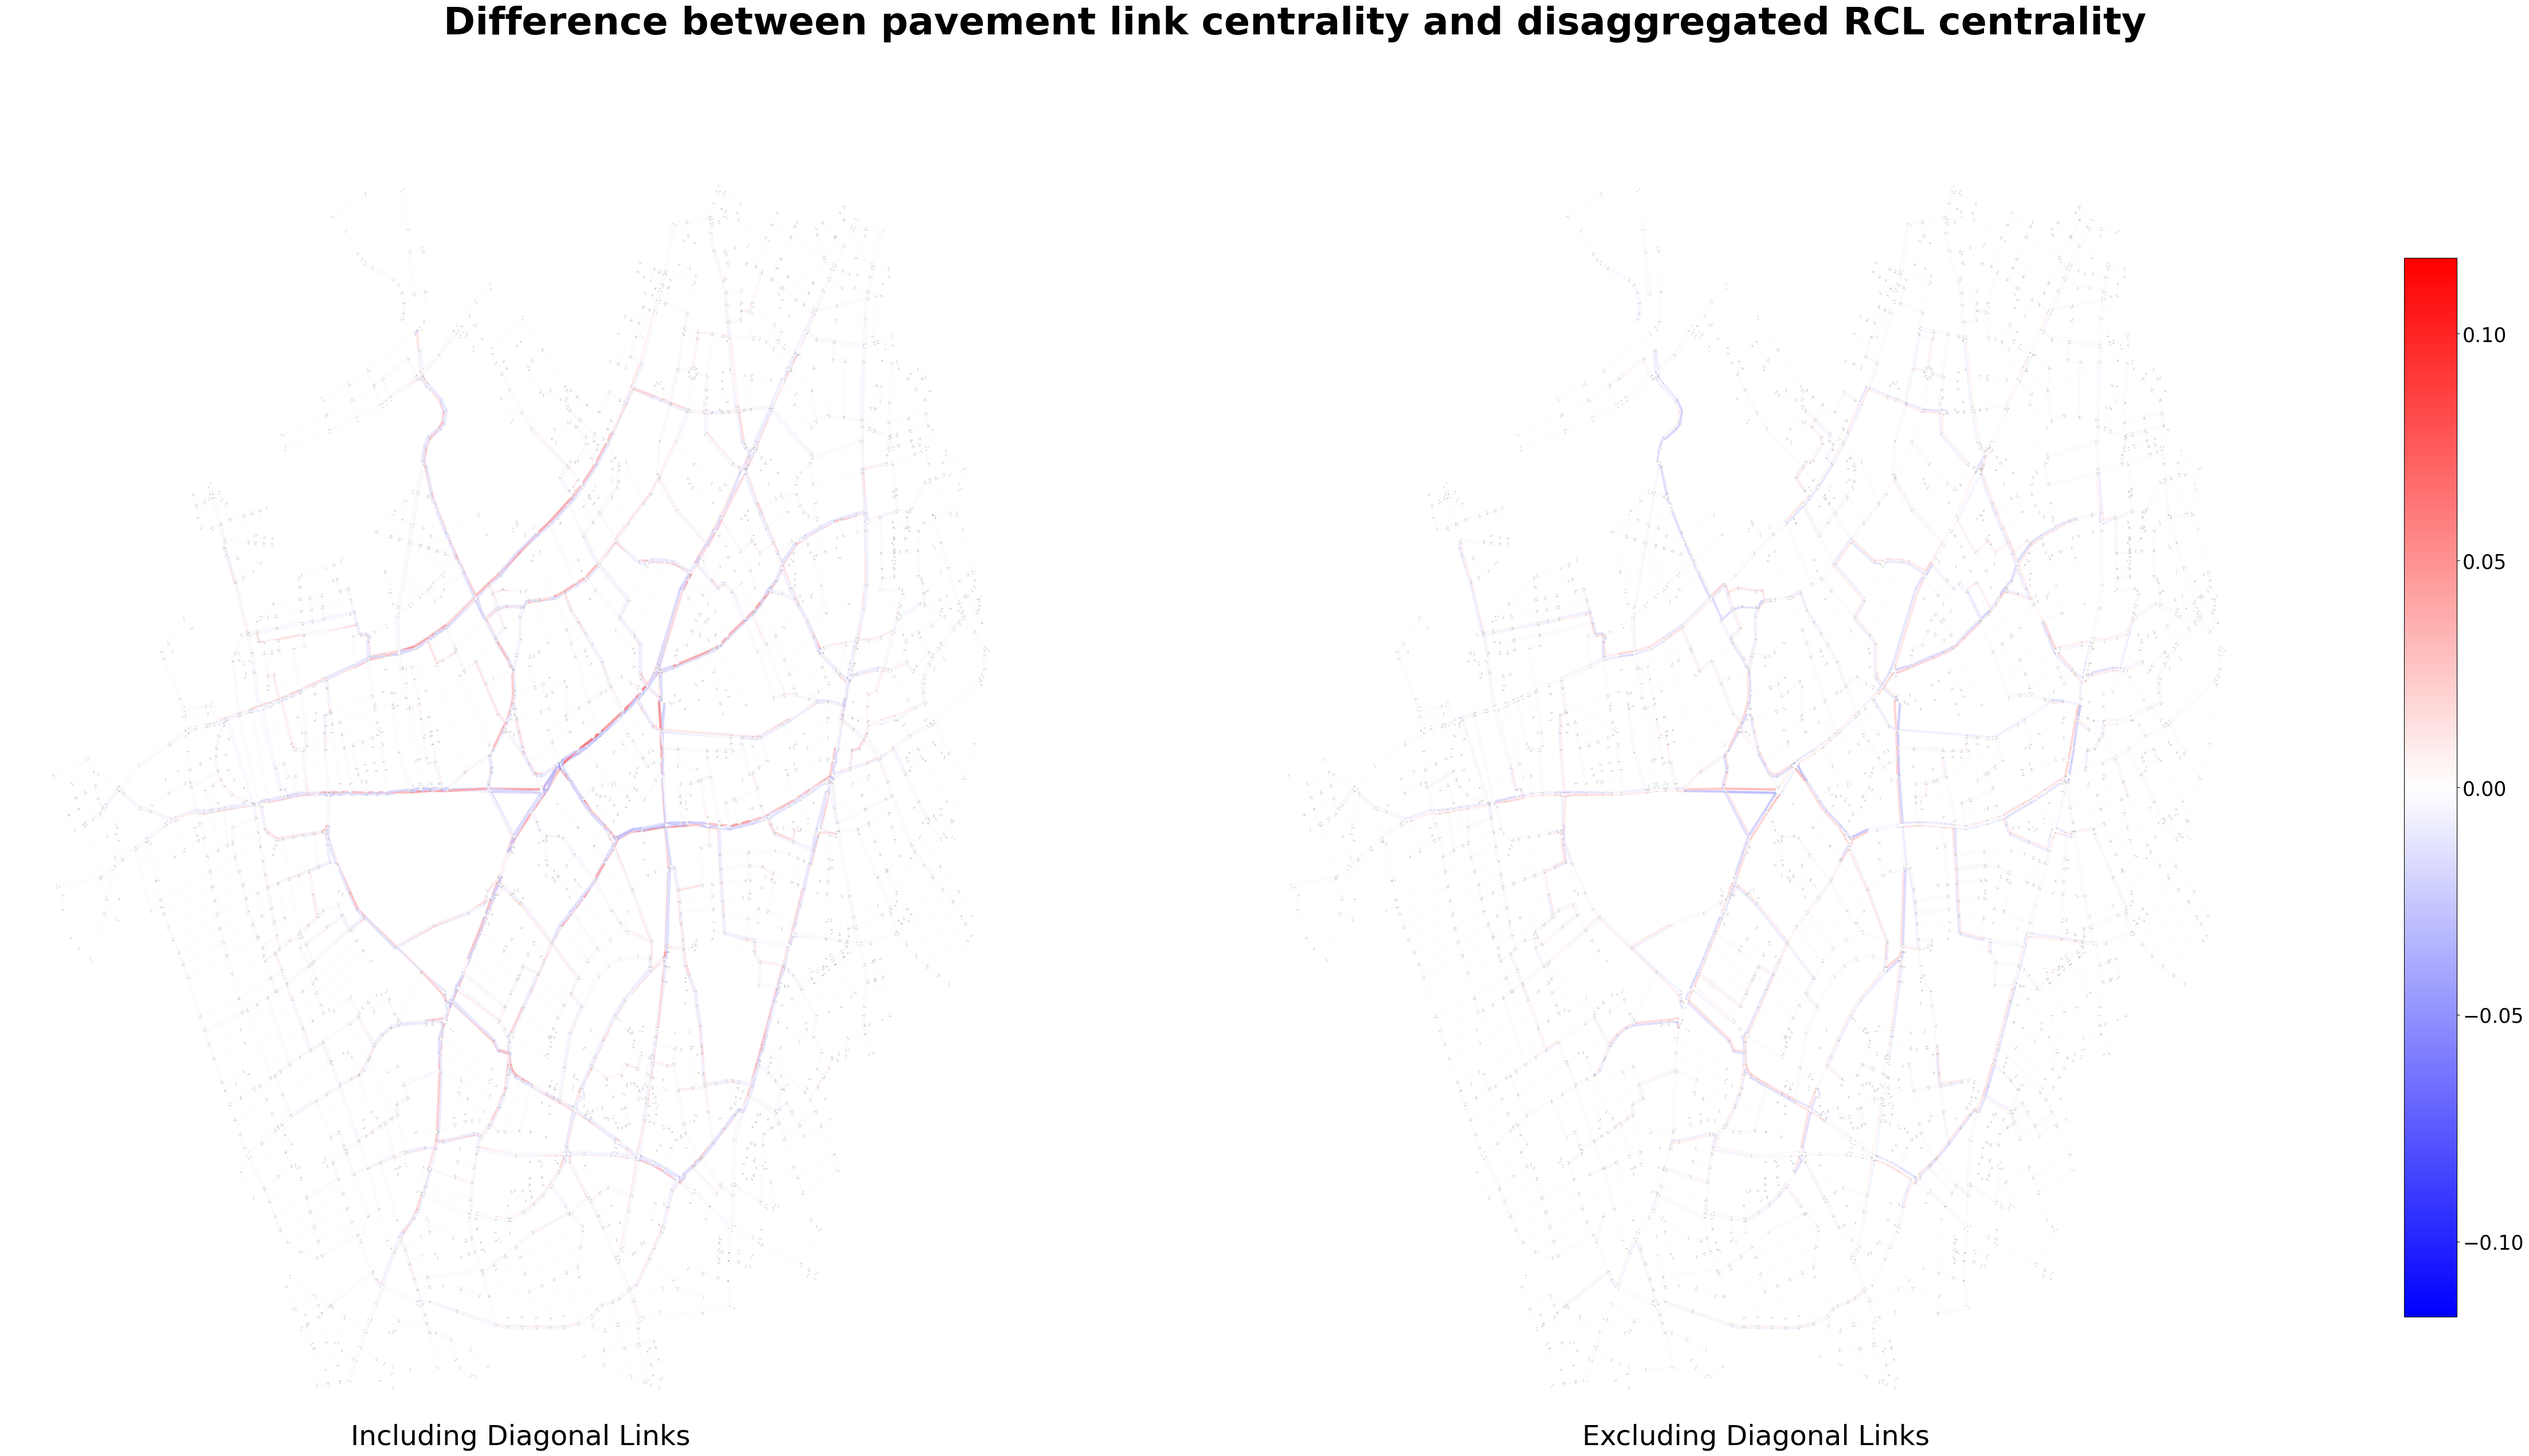

In [185]:
plt.style.use('default')


f, axs = plt.subplots(1, 2, figsize = (60,30), sharey=False, sharex=False)
        
road_network_subfigure(axs[0], G_BCDiff, dict_node_pos, "Including Diagonal Links", edge_color = bcdiff_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
road_network_subfigure(axs[1], G_BCDiffExDi, dict_node_pos, "Excluding Diagonal Links", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)

# Add colourbars
smap = plt.cm.ScalarMappable(cmap="bwr", norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(smap, ax=axs, fraction=0.1, shrink = 0.8)
cbar.ax.tick_params(labelsize=25)

# Just a single colour bar might be better, requires using same vmin and vmax for both network drawings.

_ = f.suptitle("Difference between pavement link centrality and disaggregated RCL centrality", y = 0.95, fontsize=48, weight = 'bold')

### Using difference values calculated using average of pavement link centralities

C:\Users\obisargoni\.conda\envs\gforge\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\obisargoni\.conda\envs\gforge\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


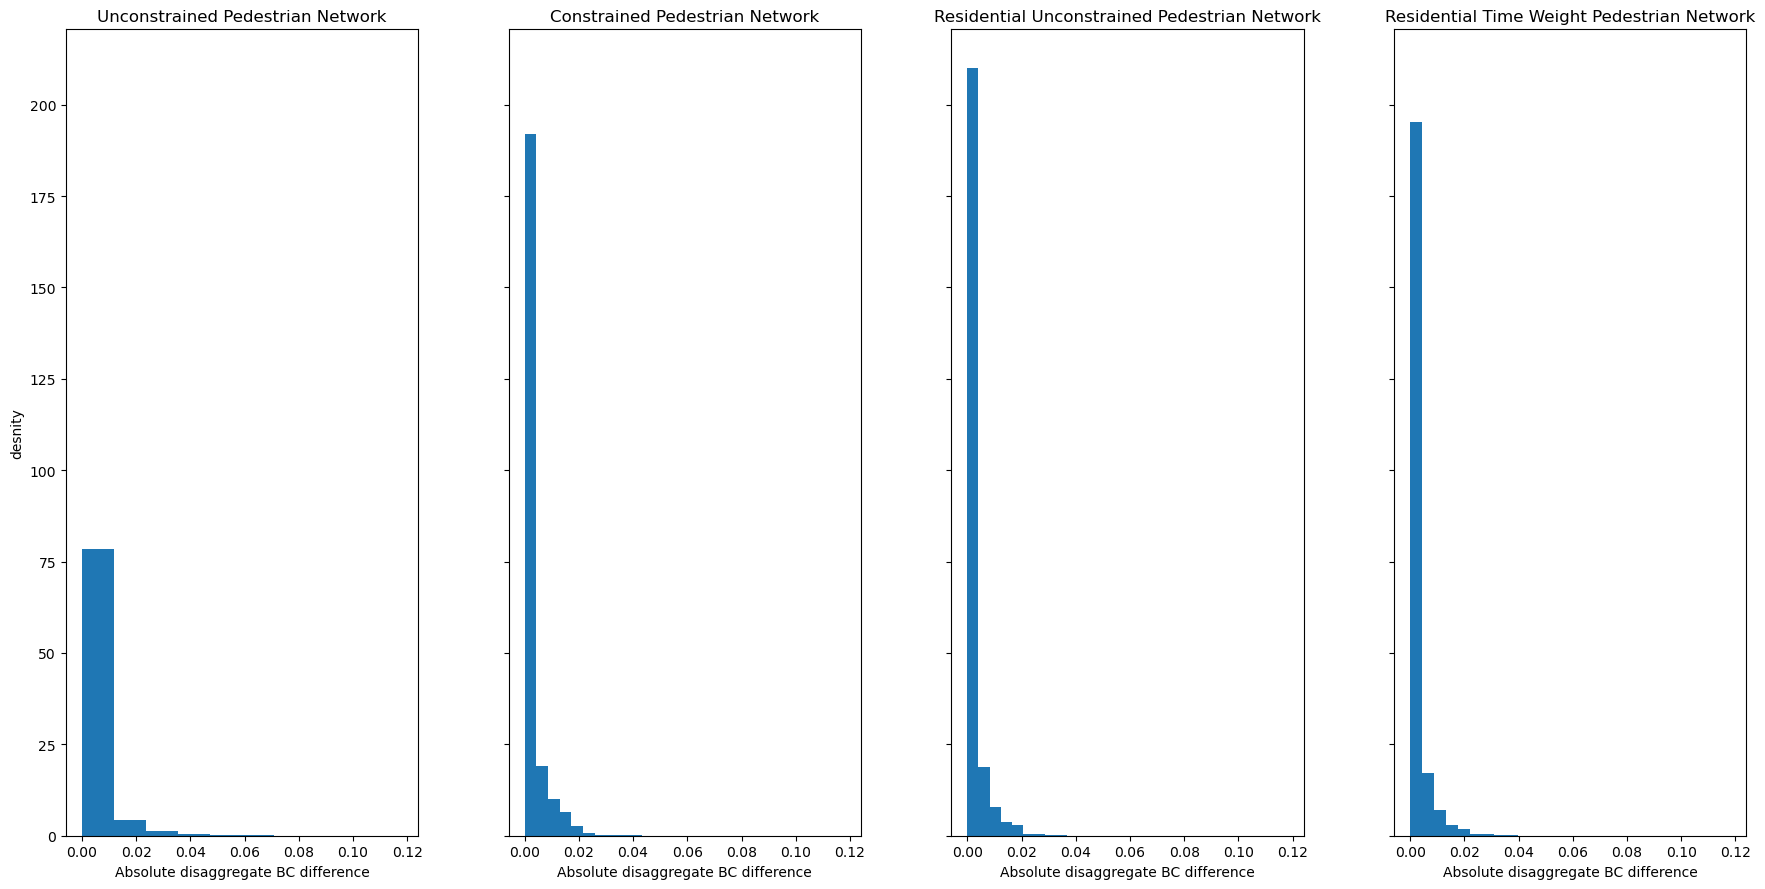

In [186]:
n_bins = 10
fig, axs = plt.subplots(1, 4, figsize = (18,9), sharey=True, sharex=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
_ = axs[0].hist(abs(gdfPaveBC['BCDiffPv']), bins=n_bins, density=True)
_ = axs[1].hist(abs(gdfPaveExDiagBC['BCDfExDiPv']), bins=n_bins, density=True)
_ = axs[2].hist(abs(gdfPaveResBC['BCDfResPv']), bins=n_bins, density=True)
_ = axs[3].hist(abs(gdfPaveRTBC['BCDfRTPv']), bins=n_bins, density=True)

axs[0].set_ylabel("desnity")
for ax in axs:
    ax.set_xlabel("Absolute disaggregate BC difference")

titles = [  "Unconstrained Pedestrian Network",
            "Constrained Pedestrian Network",
            "Residential Unconstrained Pedestrian Network",
            "Residential Time Weight Pedestrian Network"
         ]
    
for i, title in enumerate(titles):
    axs[i].set_title(title)

In [187]:
from scipy import stats

In [188]:
# Comparing means

# Assuming from imdependent samples
scipy.stats.ttest_ind(gdfPaveExDiagBC['BCDfExDiPv'].dropna(), gdfPaveResBC['BCDfResPv'].dropna())

Ttest_indResult(statistic=2.3100094779108558e-14, pvalue=0.9999999999999816)

In [189]:
scipy.stats.ttest_ind(gdfPaveExDiagBC['BCDfExDiPv'].dropna(), gdfPaveRTBC['BCDfRTPv'].dropna())

Ttest_indResult(statistic=-8.708615336768822e-14, pvalue=0.9999999999999305)

In [190]:
scipy.stats.ttest_ind(gdfPaveResBC['BCDfResPv'].dropna(), gdfPaveRTBC['BCDfRTPv'].dropna())

Ttest_indResult(statistic=-1.3604608514937896e-13, pvalue=0.9999999999998914)

The histograms show that when dissaggregate bc difference is calculated relative to the average pavment network bc values the same overall pattern is oserved (greater differences between sides of the road when diagonal links included) but that the magnitudes of the differences are smaller.

Comparing means shows that the difference in barrier effect representation has not made a significant difference to the centralities between sides of the road.

In [191]:
# Try again assuming related samples
data = pd.merge(gdfPaveExDiagBC.loc[gdfPaveExDiagBC['linkType']!='direct_cross', ['BCDfExDiPv', 'fid']], gdfPaveResBC.loc[:, ['BCDfResPv', 'fid']]).dropna()
print(scipy.stats.ttest_ind( abs(data['BCDfExDiPv']), abs(data['BCDfResPv'])))
print(abs(data['BCDfExDiPv']).mean(), abs(data['BCDfResPv']).mean())

Ttest_indResult(statistic=-1.0738041342560323, pvalue=0.28292862858995316)
0.002433416550472063 0.002511878271747557


In [192]:
data = pd.merge(gdfPaveExDiagBC.loc[:, ['BCDfExDiPv', 'fid']], gdfPaveRTBC.loc[:, ['BCDfRTPv', 'fid']]).dropna()
scipy.stats.ttest_ind(data['BCDfExDiPv'], data['BCDfRTPv'])

Ttest_indResult(statistic=-1.2502677433823635, pvalue=0.21122225351018192)

In [193]:
data = pd.merge(gdfPaveResBC.loc[:, ['BCDfResPv', 'fid']], gdfPaveRTBC.loc[:, ['BCDfRTPv', 'fid']]).dropna()
scipy.stats.ttest_ind(data['BCDfResPv'], data['BCDfRTPv'])

Ttest_indResult(statistic=-1.3604608514937896e-13, pvalue=0.9999999999998914)

In [198]:
data = pd.merge(gdfPaveBC.loc[:, ['BCDiffPv', 'fid']], gdfPaveResBC.loc[:, ['BCDfResPv', 'fid']]).dropna()
scipy.stats.ttest_ind( abs(data['BCDiffPv']), abs(data['BCDfResPv']) )

Ttest_indResult(statistic=9.406861669871123, pvalue=5.538044178605926e-21)

In [199]:
scipy.stats.ttest_rel( abs(data['BCDiffPv']), abs(data['BCDfResPv']) )

Ttest_relResult(statistic=15.304153133068803, pvalue=2.146311605119839e-52)

In [201]:
data = pd.merge(gdfPaveBC.loc[:, ['BCDiffPv', 'fid']], gdfPaveExDiagBC.loc[:, ['BCDfExDiPv', 'fid']]).dropna()
scipy.stats.ttest_ind( abs(data['BCDiffPv']), abs(data['BCDfExDiPv']))

Ttest_indResult(statistic=10.603772350482426, pvalue=3.5811848407122495e-26)

In [202]:
scipy.stats.ttest_rel( abs(data['BCDiffPv']), abs(data['BCDfExDiPv']))

Ttest_relResult(statistic=15.66496521211403, pvalue=2.0997647464947556e-54)

In [216]:
# Means
print("CPN:{} +- {}".format(abs(gdfPaveExDiagBC['BCDfExDiPv']).mean(), abs(gdfPaveExDiagBC['BCDfExDiPv']).sem()))
print("RUPN:{} +- {}".format(abs(gdfPaveResBC['BCDfResPv']).mean(), abs(gdfPaveResBC['BCDfResPv']).sem()))
print("UPN:{} +- {}".format(abs(gdfPaveBC['BCDiffPv']).mean(), abs(gdfPaveBC['BCDiffPv']).sem()))

CPN:0.0024334165504720636 +- 5.101426565480554e-05
RUPN:0.002060564200763851 +- 3.391866854900484e-05
UPN:0.0032172781491798274 +- 5.437396486126618e-05


In [208]:
abs(gdfPaveExDiagBC['BCDfExDiPv']).std()

0.004310026210307169

In [209]:
abs(gdfPaveExDiagBC['BCDfExDiPv']).dropna().shape

(7138,)

In [210]:
abs(gdfPaveExDiagBC['BCDfExDiPv']).sem()

5.101426565480554e-05

In [212]:
0.00431/np.sqrt(7138)

5.1013955424772685e-05

In [37]:
gdfPaveExDiagBC['BCDfExDiPv'].describe()

count    7.138000e+03
mean    -2.771139e-19
std      4.949613e-03
min     -4.311788e-02
25%     -5.980946e-04
50%      0.000000e+00
75%      5.980946e-04
max      4.311788e-02
Name: BCDfExDiPv, dtype: float64

In [50]:
# Get networkx graph
G_BCDiff = nx.Graph()
edges = gdfPaveBC.loc[ gdfPaveBC['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'BCDiffPv']].dropna().values
G_BCDiff.add_weighted_edges_from(edges, weight = 'BCDiffPv')

G_BCDiffExDi = nx.Graph()
edges = gdfPaveExDiagBC.loc[gdfPaveExDiagBC['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'BCDfExDiPv']].dropna().values
G_BCDiffExDi.add_weighted_edges_from(edges, weight = 'BCDfExDiPv')

G_BCDiffRes = nx.Graph()
edges = gdfPaveResBC.loc[gdfPaveResBC['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'BCDfResPv']].dropna().values
G_BCDiffRes.add_weighted_edges_from(edges, weight = 'BCDfResPv')

G_BCDiffRT = nx.Graph()
edges = gdfPaveRTBC.loc[gdfPaveRTBC['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'BCDfRTPv']].dropna().values
G_BCDiffRT.add_weighted_edges_from(edges, weight = 'BCDfRTPv')

# get edge data to color edges by
bcdiff_data = np.array([d[-1] for d in  G_BCDiff.edges.data('BCDiffPv', default=0)])
bcdiff_exdi_data = np.array([d[-1] for d in G_BCDiffExDi.edges.data('BCDfExDiPv', default=0)])
bcdiff_res_data = np.array([d[-1] for d in G_BCDiffRes.edges.data('BCDfResPv', default=0)])
bcdiff_rt_data = np.array([d[-1] for d in G_BCDiffRT.edges.data('BCDfRTPv', default=0)])

In [51]:
# Get ratio of study are height : width
study_area_bounds = gdfPaveBC.total_bounds
width = study_area_bounds[2] - study_area_bounds[0]
height = study_area_bounds[3] - study_area_bounds[1]

htow = height / width

C:\Anaconda3\envs\geoforge\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Anaconda3\envs\geoforge\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
C:\Anaconda3\envs\geoforge\lib\site-packages\networkx\drawing\nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


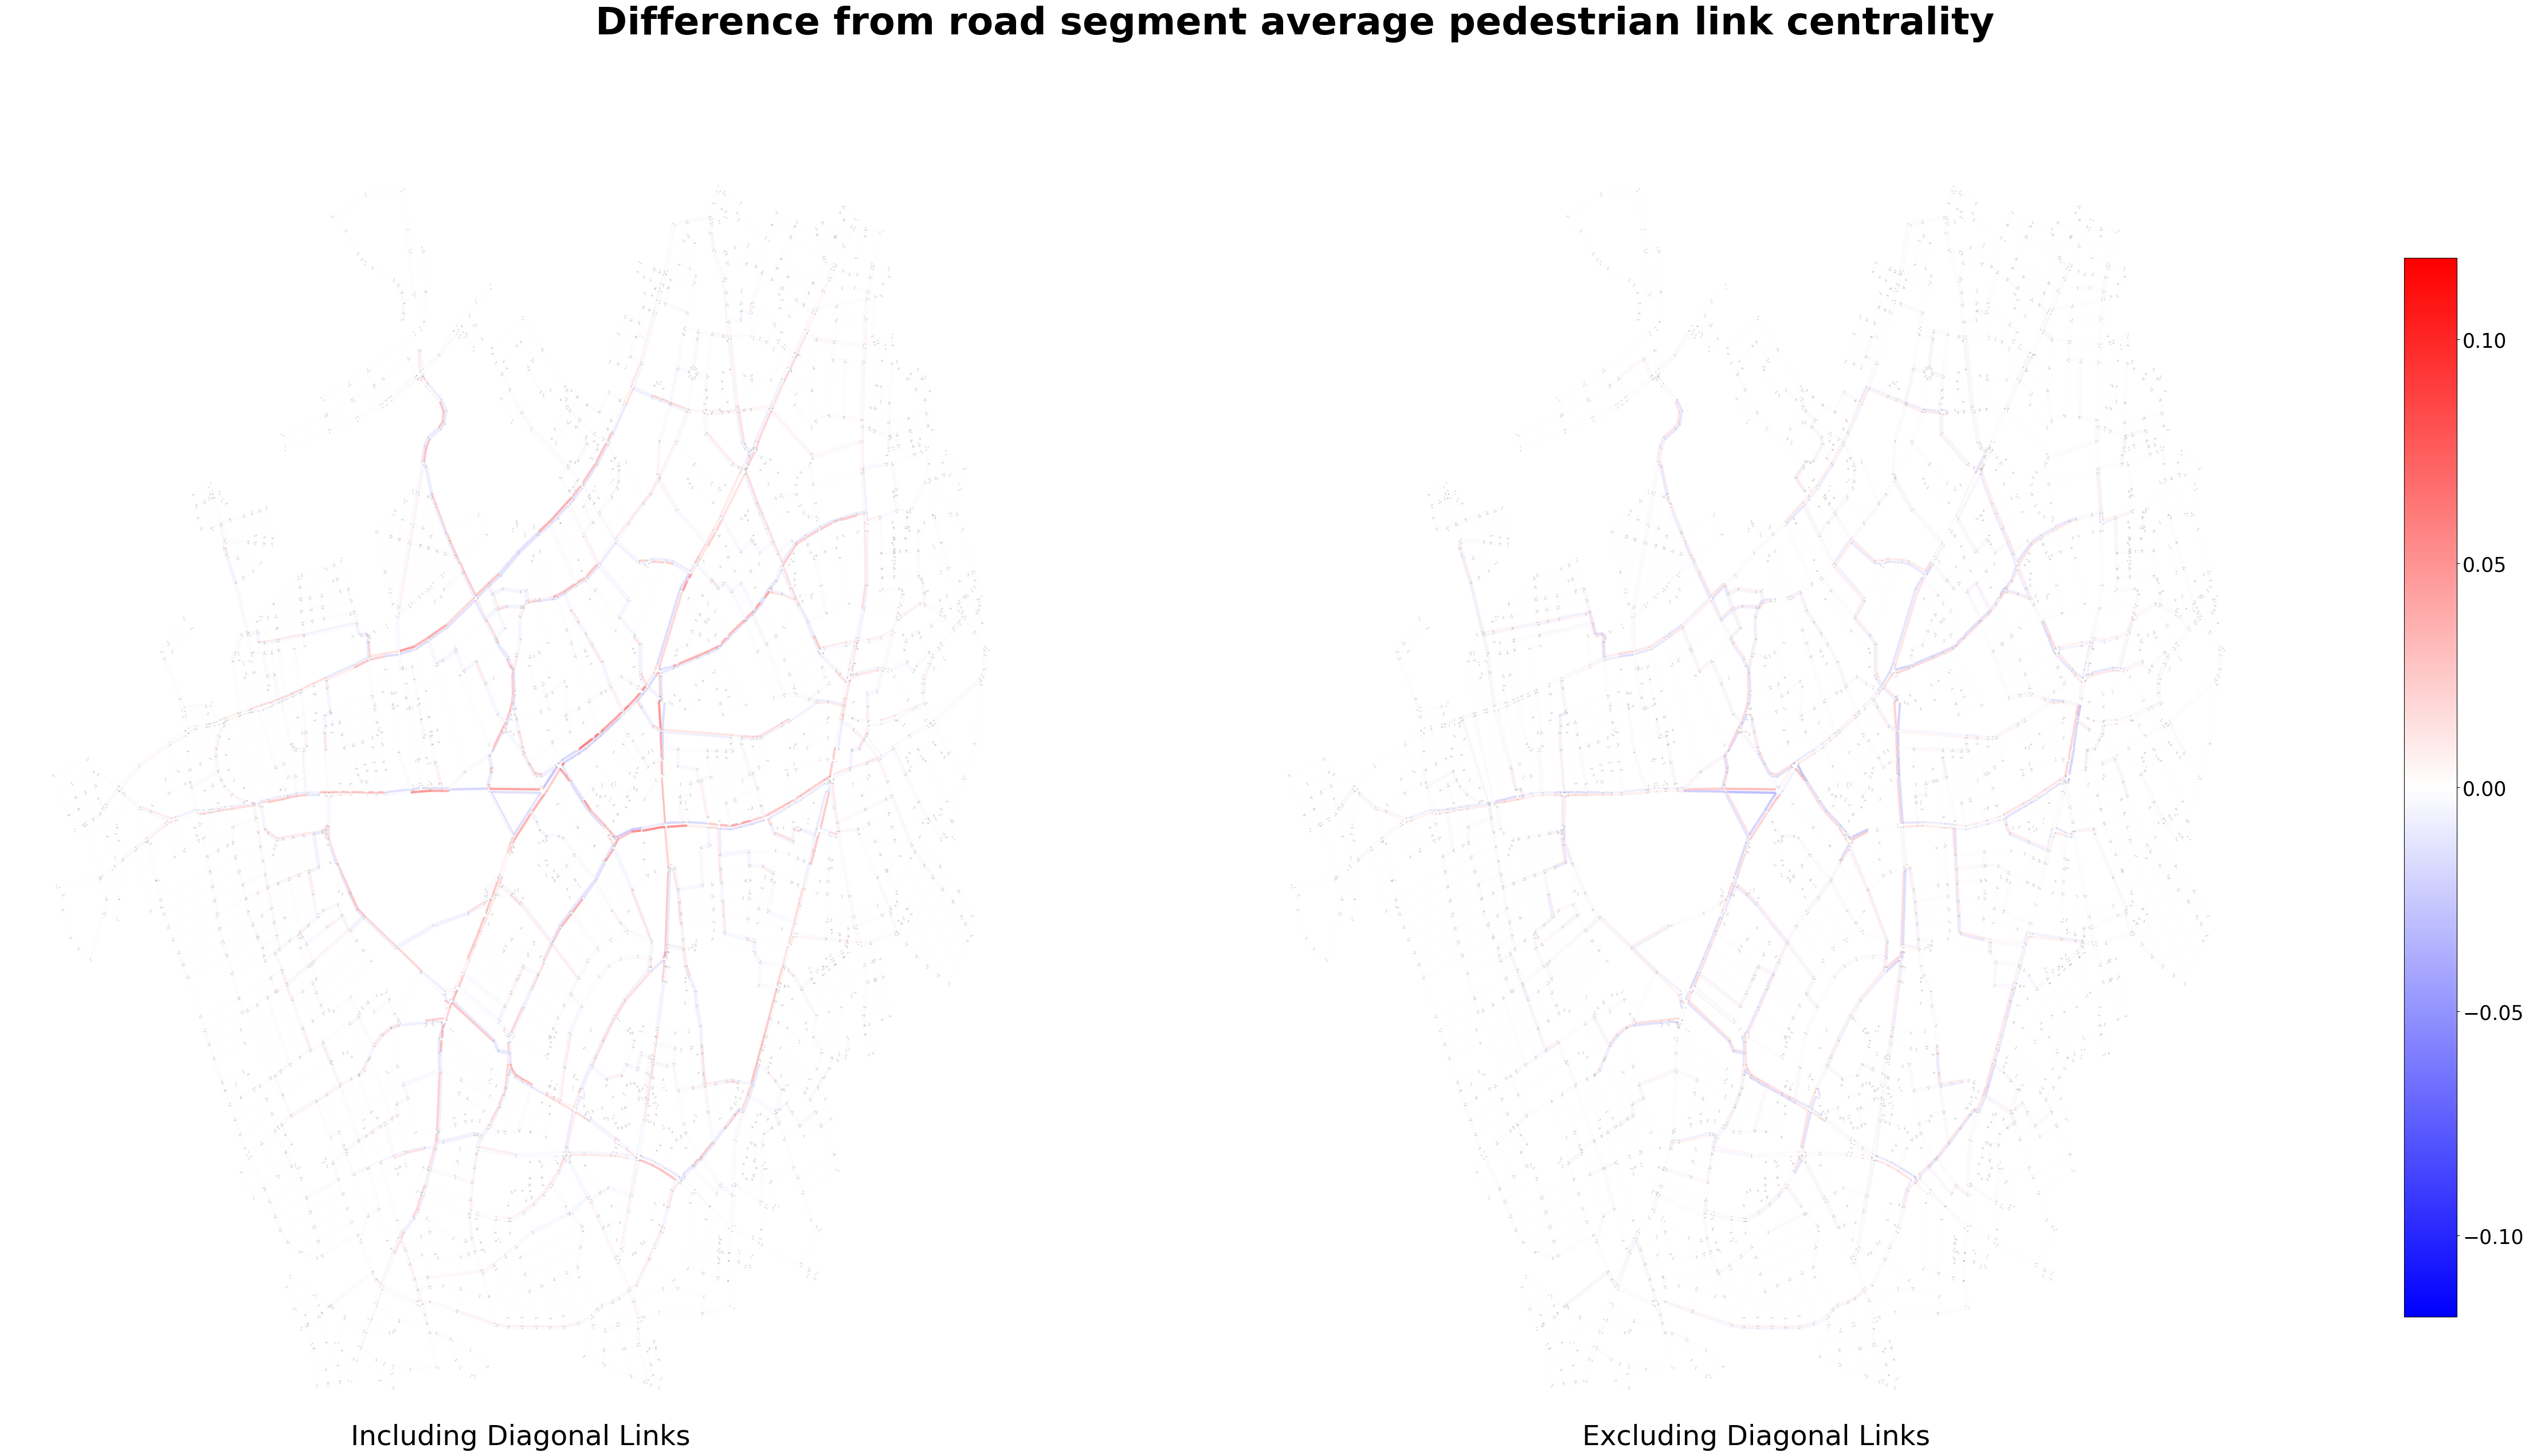

In [52]:
plt.style.use('default')

all_values = np.concatenate([bcdiff_data, bcdiff_exdi_data])
vmin = -1*max(abs(all_values))
vmax = max(abs(all_values))


f, axs = plt.subplots(1, 2, figsize = (60,30), sharey=False, sharex=False)
        
road_network_subfigure(axs[0], G_BCDiff, dict_node_pos, "Including Diagonal Links", edge_color = bcdiff_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
road_network_subfigure(axs[1], G_BCDiffExDi, dict_node_pos, "Excluding Diagonal Links", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)

# Add colourbars
smap = plt.cm.ScalarMappable(cmap="bwr", norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(smap, ax=axs, fraction=0.1, shrink = 0.8)
cbar.ax.tick_params(labelsize=25)

# Just a single colour bar might be better, requires using same vmin and vmax for both network drawings.

_ = f.suptitle("Difference from road segment average pedestrian link centrality", y = 0.95, fontsize=48, weight = 'bold')

C:\Anaconda3\envs\geoforge\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Anaconda3\envs\geoforge\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
C:\Anaconda3\envs\geoforge\lib\site-packages\networkx\drawing\nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


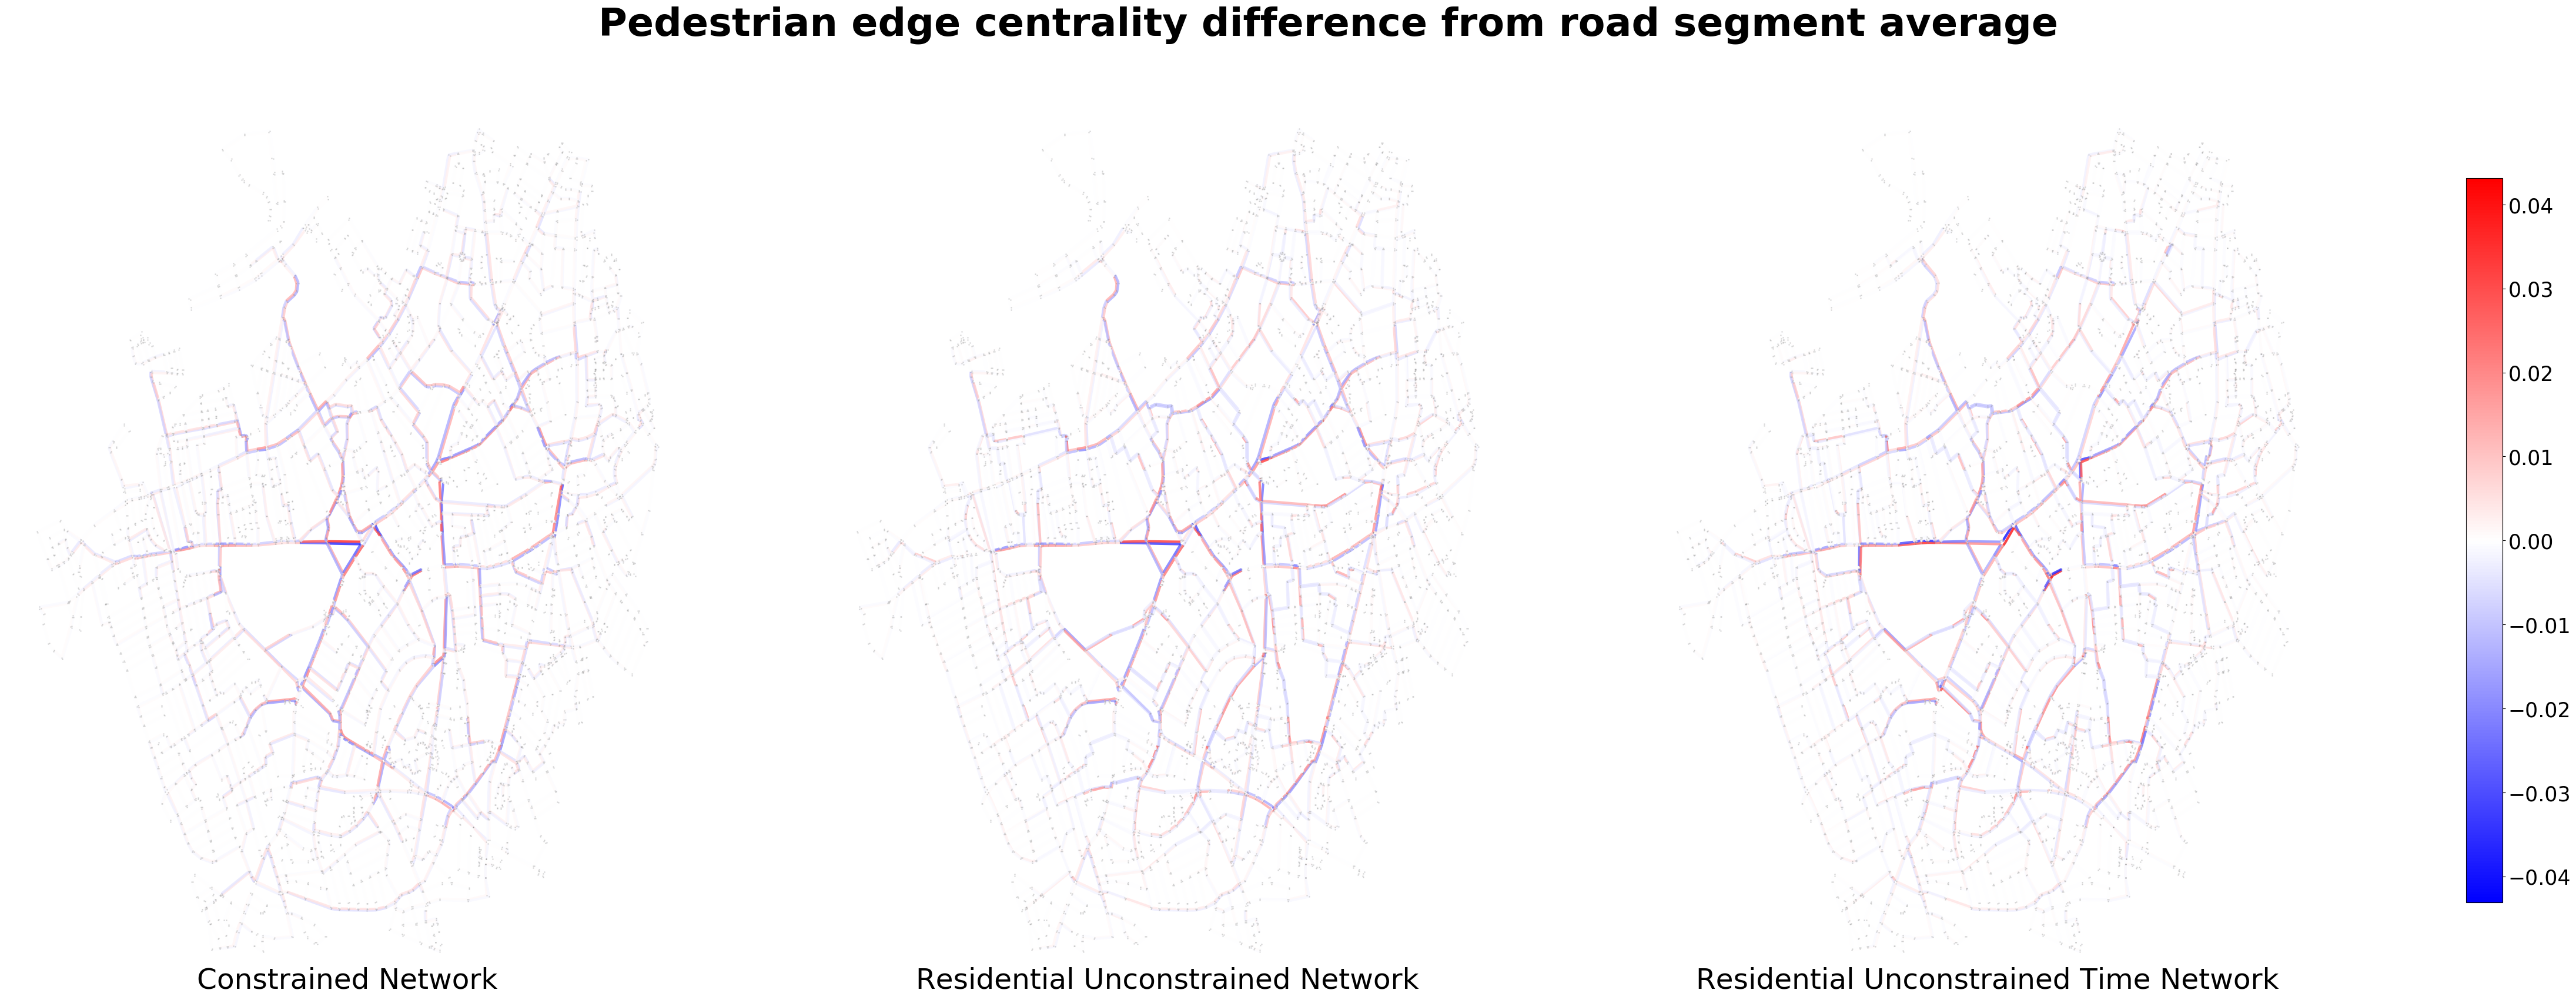

In [53]:
plt.style.use('default')

all_values = np.concatenate([bcdiff_res_data, bcdiff_exdi_data])
vmin = -1*max(abs(all_values))
vmax = max(abs(all_values))


f, axs = plt.subplots(1, 3, figsize = (60,20), sharey=False, sharex=False)
        
road_network_subfigure(axs[0], G_BCDiffExDi, dict_node_pos, "Constrained Network", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
road_network_subfigure(axs[1], G_BCDiffRes, dict_node_pos, "Residential Unconstrained Network", edge_color = bcdiff_res_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
road_network_subfigure(axs[2], G_BCDiffRT, dict_node_pos, "Residential Unconstrained Time Network", edge_color = bcdiff_rt_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)

# Add colourbars
smap = plt.cm.ScalarMappable(cmap="bwr", norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(smap, ax=axs, fraction=0.1, shrink = 0.8)
cbar.ax.tick_params(labelsize=25)

# Just a single colour bar might be better, requires using same vmin and vmax for both network drawings.

_ = f.suptitle("Pedestrian edge centrality difference from road segment average", y = 0.95, fontsize=48, weight = 'bold')

#### Inset image to show road sections with bias for one side of the road

In [54]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.patches import Rectangle

In [55]:
# Load zoom area
gdfZoom = gpd.read_file(os.path.join(data_dir, 'zoom_area.shp'))
zoom_bb = gdfZoom.total_bounds
print(zoom_bb)

[529802.48062515 175631.65687918 530320.47047476 176116.58354689]


In [56]:
# Select zoomed in data to show


C:\Anaconda3\envs\geoforge\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Anaconda3\envs\geoforge\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
C:\Anaconda3\envs\geoforge\lib\site-packages\networkx\drawing\nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


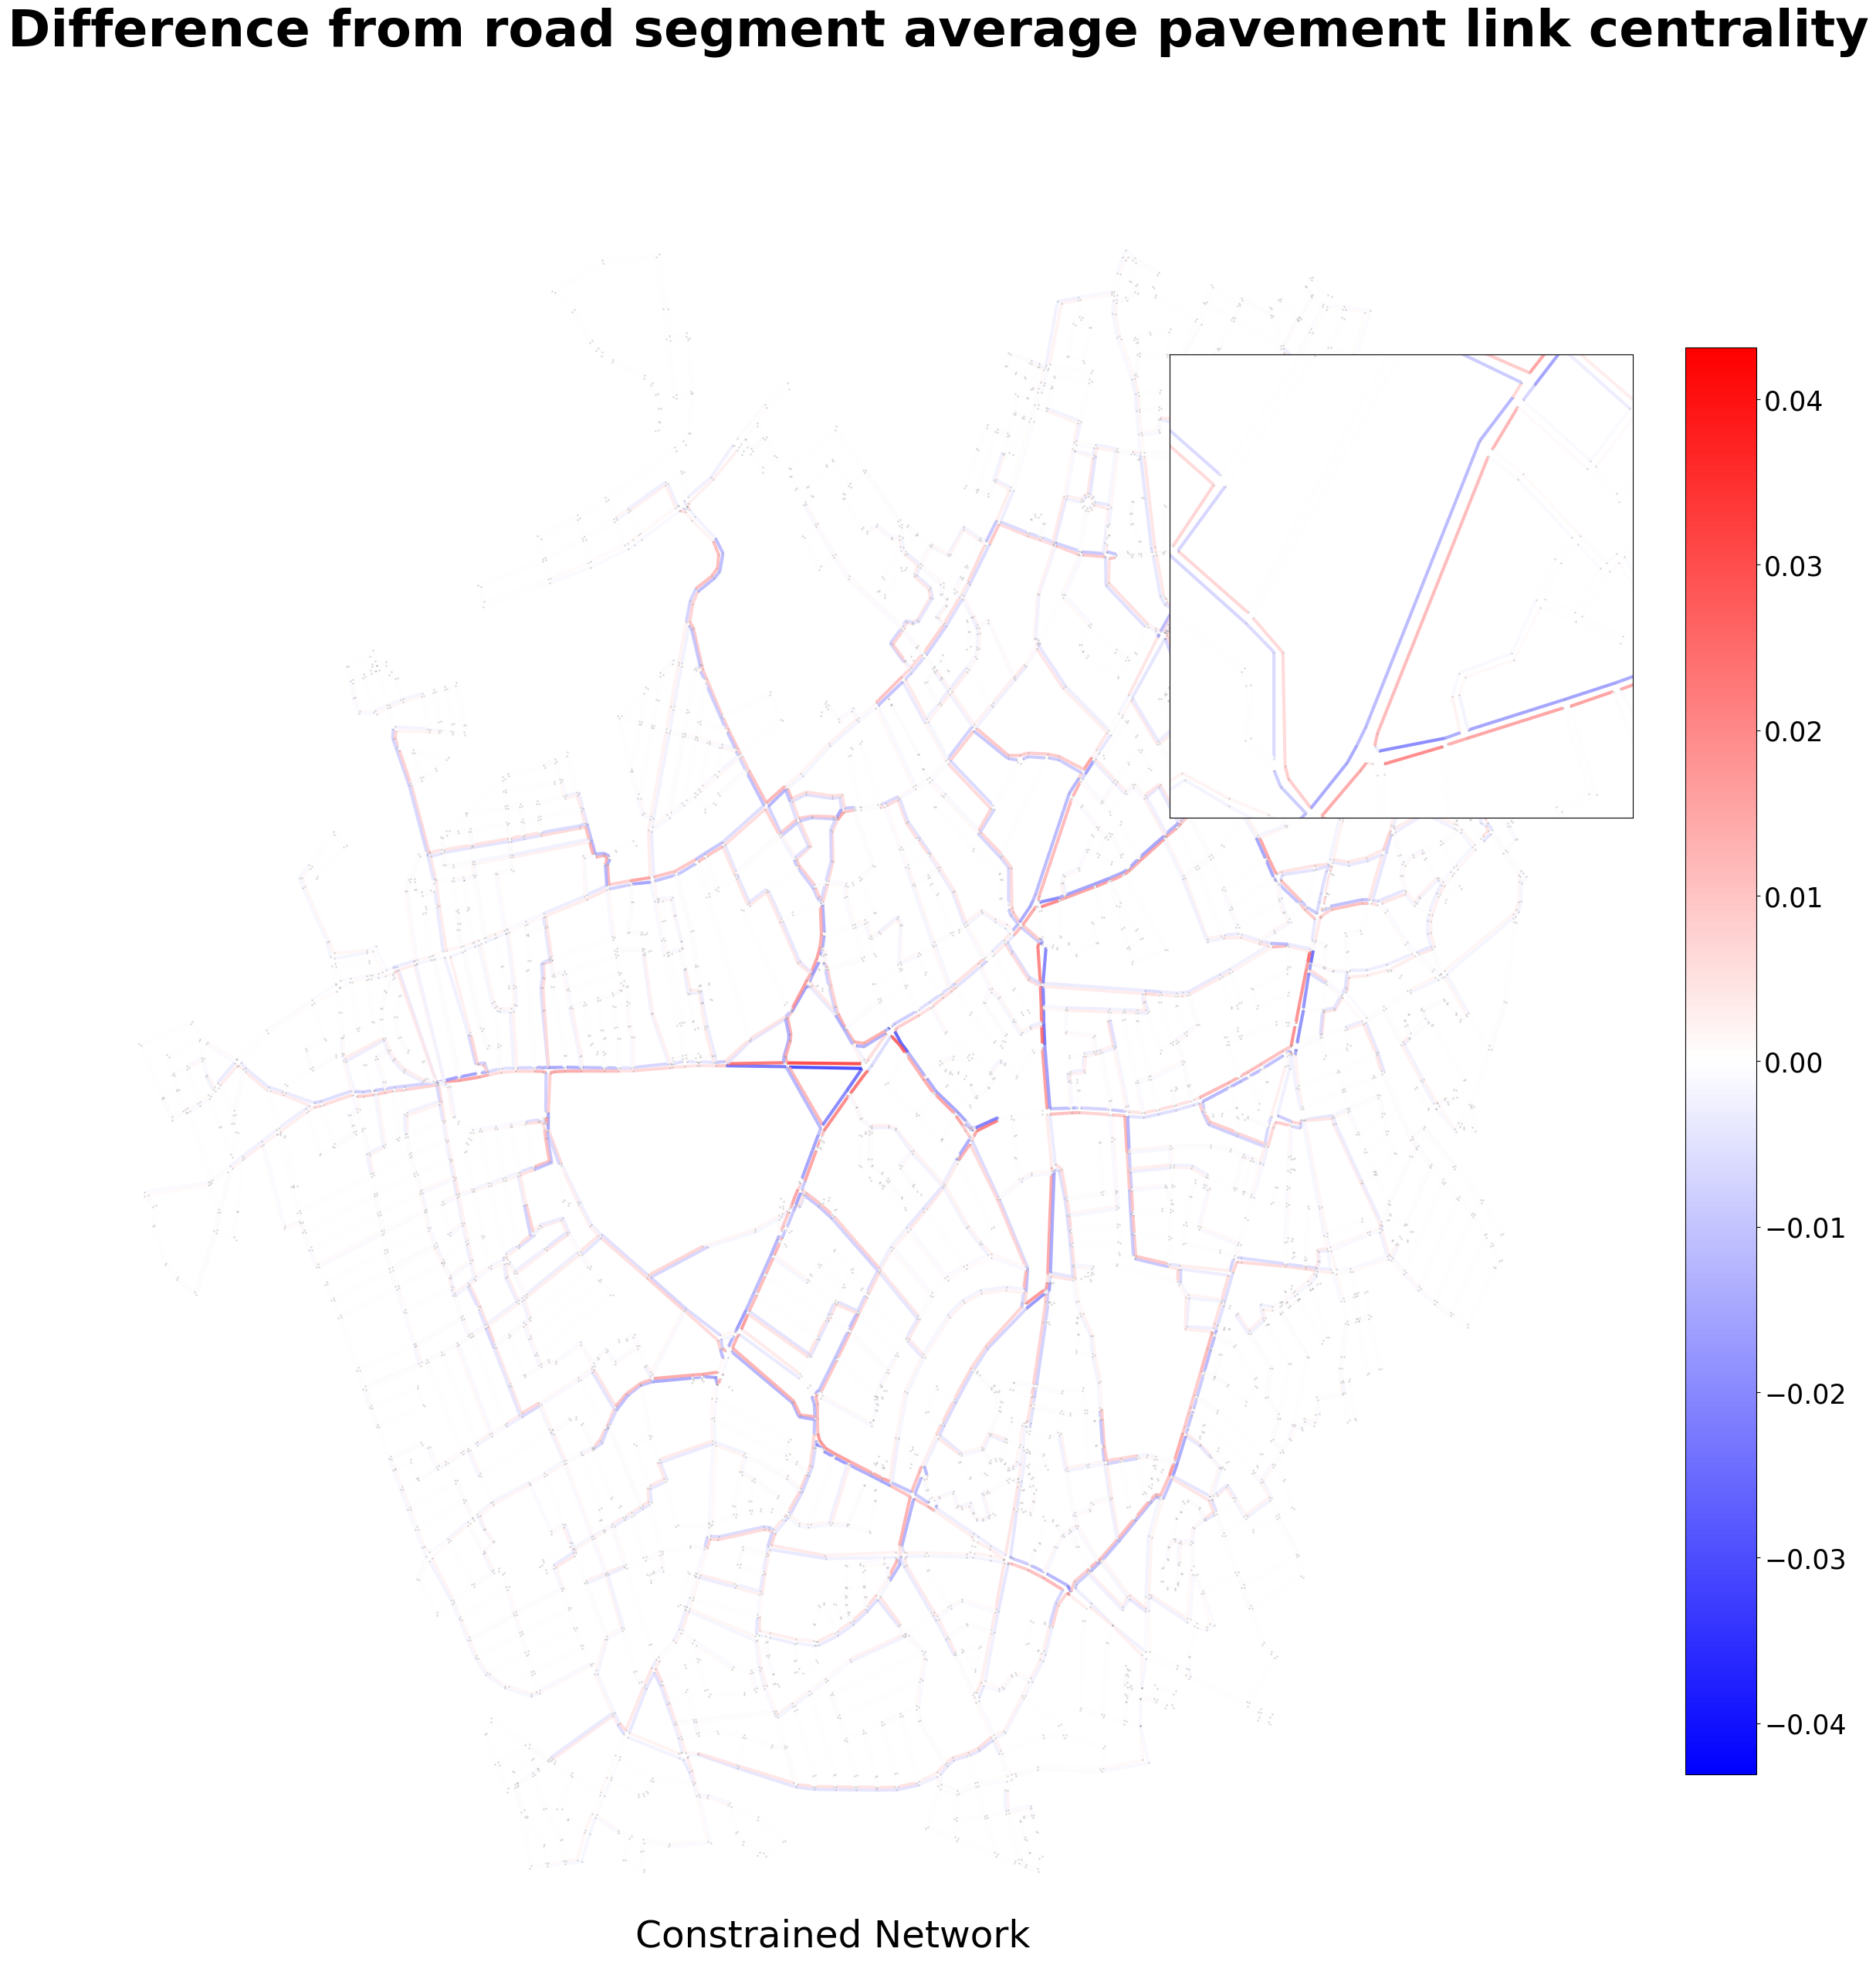

In [57]:
plt.style.use('default')

all_values = np.concatenate([bcdiff_res_data, bcdiff_exdi_data])
vmin = -1*max(abs(all_values))
vmax = max(abs(all_values))


f, ax = plt.subplots(1, 1, figsize = (30,30))
        
road_network_subfigure(ax, G_BCDiffExDi, dict_node_pos, "Constrained Network", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)

# Add colourbars
smap = plt.cm.ScalarMappable(cmap="bwr", norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(smap, ax=ax, fraction=0.1, shrink = 0.8)
cbar.ax.tick_params(labelsize=25)

# Add inset
axins = f.add_axes([0.6, 0.6, 0.2, 0.2])
road_network_subfigure(axins, G_BCDiffExDi, dict_node_pos, "", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
x1, y1, x2, y2 = zoom_bb
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Set ticks on for insert so it is clearer
axins.axis('on')

_ = f.suptitle("Difference from road segment average pavement link centrality", y = 0.95, fontsize=48, weight = 'bold')

C:\Anaconda3\envs\geoforge\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Anaconda3\envs\geoforge\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
C:\Anaconda3\envs\geoforge\lib\site-packages\networkx\drawing\nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


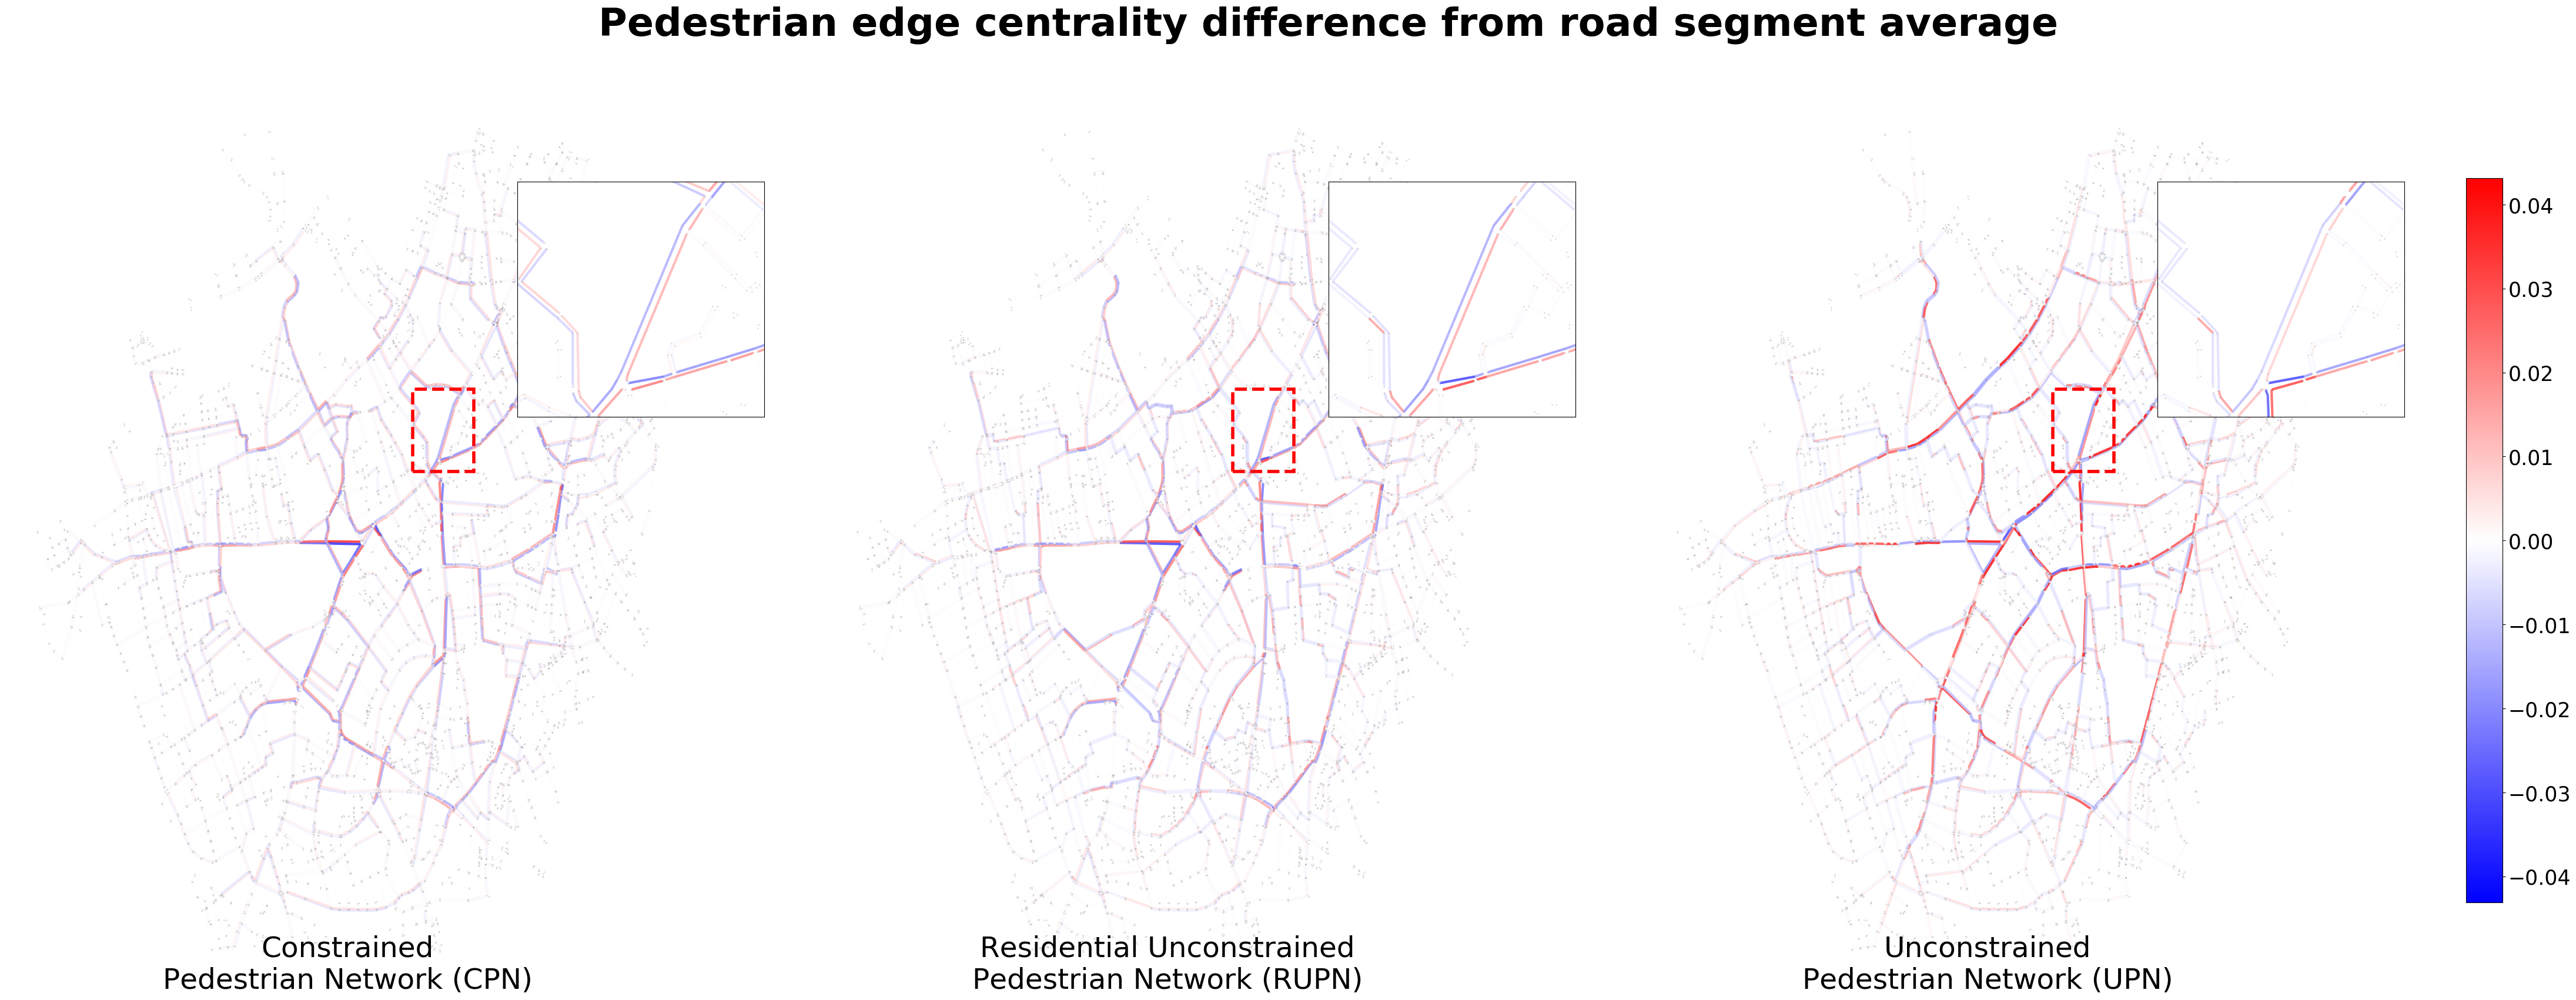

In [59]:
plt.style.use('default')

all_values = np.concatenate([bcdiff_res_data, bcdiff_exdi_data])
vmin = -1*max(abs(all_values))
vmax = max(abs(all_values))


f, axs = plt.subplots(1, 3, figsize = (60,20), sharey=False, sharex=False)
        
road_network_subfigure(axs[0], G_BCDiffExDi, dict_node_pos, "Constrained\nPedestrian Network (CPN)", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
road_network_subfigure(axs[1], G_BCDiffRes, dict_node_pos, "Residential Unconstrained\nPedestrian Network (RUPN)", edge_color = bcdiff_res_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
road_network_subfigure(axs[2], G_BCDiff, dict_node_pos, "Unconstrained\nPedestrian Network (UPN)", edge_color = bcdiff_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)

# Add rectangles indicating zoom area
x1, y1, x2, y2 = zoom_bb
axs[0].add_patch(Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', facecolor='none', lw=4, linestyle='--'))
axs[1].add_patch(Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', facecolor='none', lw=4, linestyle='--'))
axs[2].add_patch(Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', facecolor='none', lw=4, linestyle='--'))

# Add colourbars
smap = plt.cm.ScalarMappable(cmap="bwr", norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = f.colorbar(smap, ax=axs, fraction=0.1, shrink = 0.8)
cbar.ax.tick_params(labelsize=25)

# Add inset
axins = f.add_axes([0.27, 0.6, 0.07, 0.2])
road_network_subfigure(axins, G_BCDiffExDi, dict_node_pos, "", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axis('on')

axins = f.add_axes([0.25*2, 0.6, 0.07, 0.2])
road_network_subfigure(axins, G_BCDiffRes, dict_node_pos, "", edge_color = bcdiff_res_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axis('on')

axins = f.add_axes([0.245*3, 0.6, 0.07, 0.2])
road_network_subfigure(axins, G_BCDiffRT, dict_node_pos, "", edge_color = bcdiff_rt_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axis('on')

# Just a single colour bar might be better, requires using same vmin and vmax for both network drawings.

_ = f.suptitle("Pedestrian edge centrality difference from road segment average", y = 0.95, fontsize=48, weight = 'bold')

# Figures showing method for aggregating and apportioning betweenness centrality values

In [5]:
def plot_layers(ax, config, pavement = None, carriageway = None, road_link = None, road_node = None, rays = None, pavement_link = None, pavement_node = None):
    '''Keyword aarguments are geodataframes containing the shapes to be plotted
    '''
    for i, (k, v) in enumerate(locals().items()):

        # Skip no keywork arguments
        if k in ['ax', 'config']:
            continue
        if v is not None:

            if k in ['pavement','carriageway']:
                v.plot(ax=ax, color = config[k]['color'], zorder=i)
            elif k in ['road_link', 'pavement_link']:
                v.plot(ax=ax, facecolor=config[k]['color'], edgecolor = config[k]['color'], linewidth=config[k]['linewidth'], zorder=i)
            elif k in ['road_node', 'pavement_node']:
                v.plot(ax=ax, facecolor=config[k]['color'], edgecolor = config[k]['color'], linewidth=config[k]['linewidth'], zorder=i)
            elif k in ['rays']:
                v.plot(ax=ax, color=config[k]['color'], linewidth=config[k]['linewidth'], zorder=i)
            else:
                v.plot(ax=ax)

    return ax

In [152]:
def figure_bc_aggregation(road_link_id, gdfORNode, gdfORLink, gdfPedNodes, gdfPedLinks, config):
    '''figure showing how pavment bc centralities are aggregated to compare to rcl centrality
    '''
    # Initialise figure
    f, ax = plt.subplots(1,1, figsize = (10,5))

    # Select OR links and nodes - links selects include neighbouring links
    ind = gdfORLink['fid']==road_link_id
    ORNodes = pd.concat([gdfORLink.loc[ ind, 'MNodeFID'], gdfORLink.loc[ ind, 'PNodeFID']]).unique()
    gdfORLink = gdfORLink.loc[ gdfORLink['MNodeFID'].isin(ORNodes) | gdfORLink['PNodeFID'].isin(ORNodes)]
    gdfORNode = gdfORNode.loc[ gdfORNode['node_fid'].isin(ORNodes)]
    
    # Select the pavement links and nodes
    gdfPedNodes = gdfPedNodes.loc[ (gdfPedNodes['v1rlID']==road_link_id) | (gdfPedNodes['v2rlID']==road_link_id) ]
    gdfPedLinks = gdfPedLinks.loc[ gdfPedLinks['MNodeFID'].isin(gdfPedNodes['fid']) & gdfPedLinks['PNodeFID'].isin(gdfPedNodes['fid']) ]
    gdfPedLinksDiag = gdfPedLinks.loc[ gdfPedLinks['linkType']=='diag_cross']
    gdfPedLinksPave = gdfPedLinks.loc[ gdfPedLinks['linkType']=='pavement']
    gdfPedLinksDirect = gdfPedLinks.loc[ gdfPedLinks['linkType']=='direct_cross']

    # Plot these layers
    ax = plot_layers(ax, config, pavement = None, carriageway = None, road_link = gdfORLink, road_node = gdfORNode, pavement_link = gdfPedLinksDirect, pavement_node = gdfPedNodes)

    # plot diagonal and pavement links in another colour - these are links that get includeded in aggregation
    gdfAggLinks = pd.concat([gdfPedLinksPave, gdfPedLinksDiag])
    gdfAggLinks.plot(ax=ax, edgecolor = config['line_highlight_color'], linewidth=config['pavement_link']['linewidth'], linestyle = '-', zorder=7)
    
    # Add text annotations to indicate bc values
    gdfAggLinks.index = np.arange(gdfAggLinks.shape[0])
    for i, row in gdfAggLinks.iterrows():
        annotation = "$bc_{"+str(i+1)+"}$"
        x,y = row['geometry'].centroid.x, row['geometry'].centroid.y
        y = y + 1.0
        if i==2:
            x = x - 0.75
        elif i == 3:
            x = x + 0.75
        plt.text(x,y,annotation, fontdict = {'fontsize':12, 'color':config['line_highlight_color']})

    # Set limits
    xmin, ymin, xmax, ymax = gdfPedLinks.total_bounds
    ax.set_xlim(xmin-3, xmax+3)
    ax.set_ylim(ymin-5, ymax+7.5)

    ax.set_axis_off()

    return f

In [71]:
dfLinksBetCens = pd.read_csv("link_betcens_unnorm.csv")

In [86]:
fig_config = {  'pavement_link':{'color':'black', 'linewidth':2},
                'pavement_node':{'color':'black', 'linewidth':2},
                'road_node': {'color':'grey', 'linewidth':2},
                'road_link': {'color':'grey', 'linewidth':2},
              'line_highlight_color':'yellow'
                }

In [100]:
# Load pavement and OR data
data_dir = ".\\data"
img_dir = ".\\img"

pavement_network_gis_file = os.path.join(data_dir, "pedNetworkLinks.shp")
pavement_nodes_gis_file = os.path.join(data_dir, "pedNetworkNodes.shp")
road_network_gis_file = os.path.join(data_dir, "open-roads RoadLink Intersect Within simplify angles.shp")
road_nodes_gis_file = os.path.join(data_dir, "open-roads RoadNode Intersect Within simplify angles.shp")

In [101]:
gdfPedNodes = gpd.read_file(pavement_nodes_gis_file)
gdfPedLinks = gpd.read_file(pavement_network_gis_file)
gdfORLinks = gpd.read_file(road_network_gis_file)
gdfORNodes = gpd.read_file(road_nodes_gis_file)

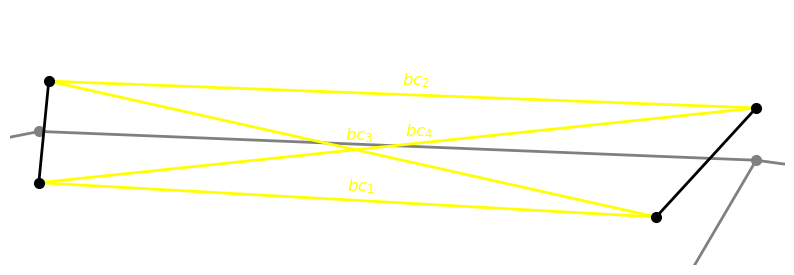

In [153]:
road_link_id = 'or_link_299'
f = figure_bc_aggregation(road_link_id, gdfORNodes, gdfORLinks, gdfPedNodes, gdfPedLinks, config=fig_config)

In [154]:
f.savefig(os.path.join(img_dir, 'bc_aggregation.png'))